# GAN example

In [12]:
# import necessary packages

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose,UpSampling2D

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [8]:
noise_dim = 100 
fs = 8

In [9]:
# creating the dataset of real images
size = 32

def create_images_vert(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(10):
            x0 = random.randrange(5,size-5)
            sample = cv2.line(sample,(x0,0),(x0,size-1),(255,255,255),1)
#         sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
#         sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def create_images_diag(num):
    samples = []
    for i in range(num):
        sample = np.zeros((size,size,1))
        for _ in range(3):
            x0 = random.randrange(-size/2,size/2)
            sample = cv2.line(sample,(x0,0),(x0+32,32),(255,255,255),2)
        sample = cv2.GaussianBlur(sample,ksize=(5,5),sigmaX=100,sigmaY=100)
        sample = np.expand_dims(sample,axis=2)
        samples.append(sample)
    return samples

def load_images(dir):
    samples = []
    for image_file in os.listdir(dir):
        if image_file.endswith("jpg"):
            sample = cv2.imread(f"{dir}/{image_file}")
            sample = cv2.resize(sample, (32,32))
            sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
            sample = np.expand_dims(sample,axis=2)
            samples.append(sample)
    return samples

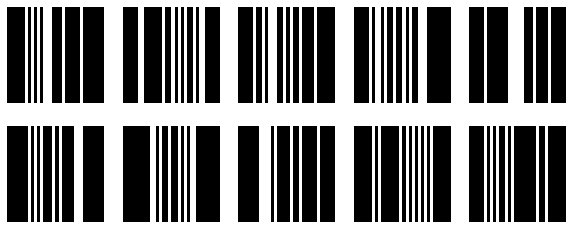

In [10]:
#samples = create_images_diag(1000)
samples = create_images_vert(1000)
#samples = load_images('signs')
samples = np.array(samples)
samples = samples/255

plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i][:,:,0],cmap='gray')
    #plt.title(labels[i])
    plt.axis("off")

In [13]:
# Generator gets a noise vector of size noise_dim and generates an image of size (32 x 32 x 1)
# Our aim: we want the image to be as similar to real images (generated above) as possible
def make_generator_model():
    model = Sequential()
    model.add(Dense(8*8*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 256)))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False)) 
    
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(Dropout(0.3))
    # output: 8 x 8 x 128

    model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest"))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    # output: 16 x 16 x 64

    model.add(UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest"))
    model.add(Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid'))
    # output: 32 x 32 x 1 (our image)

    model.summary()
    return model

generator = make_generator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_2 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)        

In [14]:
# Discriminator gets image of size (32 x 32 x 1) and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    # output: one number 0-fake, 1-real
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [15]:
# returns randomly choosen n real samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)    

    return new_samples

In [16]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
#cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [17]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator(input_noise, training=True)
        # evaluate fake images
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator wants all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print(f"Epoch {epoch} gen_loss={gen_loss.numpy():.3f} disc_loss={disc_loss.numpy():.3f} real_acc={real_acc} fake_acc={fake_acc}")

    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

In [18]:
def show_results(epoch):
    # show one real image and some fake images generated by generator using noise seed
    num_examples_to_generate = 6
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(10,10))
    r = random.randrange(len(samples))
    plt.subplot(1, num_examples_to_generate+1, 1)
    #plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.imshow(samples[r, :, :, 0], cmap='gray')
    plt.axis('off')
    for i in range(predictions.shape[0]):
        plt.subplot(1, num_examples_to_generate+1, i+2)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()    


Epoch 0 gen_loss=0.666 disc_loss=0.704 real_acc=0.54 fake_acc=0.24


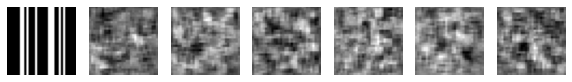

Epoch 1 gen_loss=0.701 disc_loss=0.695 real_acc=0.34 fake_acc=0.56
Epoch 2 gen_loss=0.743 disc_loss=0.681 real_acc=0.28 fake_acc=0.88
Epoch 3 gen_loss=0.777 disc_loss=0.665 real_acc=0.3 fake_acc=0.98
Epoch 4 gen_loss=0.808 disc_loss=0.664 real_acc=0.12 fake_acc=1.0
Epoch 5 gen_loss=0.832 disc_loss=0.654 real_acc=0.16 fake_acc=1.0
Epoch 6 gen_loss=0.856 disc_loss=0.654 real_acc=0.0 fake_acc=1.0
Epoch 7 gen_loss=0.882 disc_loss=0.643 real_acc=0.06 fake_acc=1.0
Epoch 8 gen_loss=0.922 disc_loss=0.629 real_acc=0.04 fake_acc=1.0
Epoch 9 gen_loss=0.953 disc_loss=0.622 real_acc=0.0 fake_acc=1.0
Epoch 10 gen_loss=0.972 disc_loss=0.623 real_acc=0.02 fake_acc=1.0


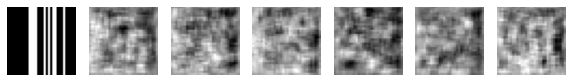

Epoch 11 gen_loss=0.995 disc_loss=0.618 real_acc=0.02 fake_acc=1.0
Epoch 12 gen_loss=1.026 disc_loss=0.604 real_acc=0.02 fake_acc=1.0
Epoch 13 gen_loss=1.046 disc_loss=0.603 real_acc=0.0 fake_acc=1.0
Epoch 14 gen_loss=1.083 disc_loss=0.589 real_acc=0.04 fake_acc=1.0
Epoch 15 gen_loss=1.091 disc_loss=0.588 real_acc=0.06 fake_acc=1.0
Epoch 16 gen_loss=1.102 disc_loss=0.582 real_acc=0.06 fake_acc=1.0
Epoch 17 gen_loss=1.125 disc_loss=0.572 real_acc=0.1 fake_acc=1.0
Epoch 18 gen_loss=1.143 disc_loss=0.570 real_acc=0.12 fake_acc=1.0
Epoch 19 gen_loss=1.149 disc_loss=0.563 real_acc=0.2 fake_acc=1.0
Epoch 20 gen_loss=1.164 disc_loss=0.554 real_acc=0.18 fake_acc=1.0


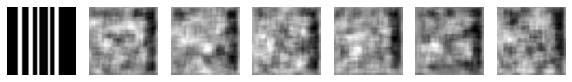

Epoch 21 gen_loss=1.158 disc_loss=0.556 real_acc=0.28 fake_acc=1.0
Epoch 22 gen_loss=1.150 disc_loss=0.549 real_acc=0.26 fake_acc=1.0
Epoch 23 gen_loss=1.151 disc_loss=0.545 real_acc=0.42 fake_acc=1.0
Epoch 24 gen_loss=1.145 disc_loss=0.543 real_acc=0.4 fake_acc=1.0
Epoch 25 gen_loss=1.154 disc_loss=0.537 real_acc=0.6 fake_acc=1.0
Epoch 26 gen_loss=1.117 disc_loss=0.539 real_acc=0.6 fake_acc=1.0
Epoch 27 gen_loss=1.128 disc_loss=0.537 real_acc=0.7 fake_acc=1.0
Epoch 28 gen_loss=1.106 disc_loss=0.534 real_acc=0.76 fake_acc=1.0
Epoch 29 gen_loss=1.093 disc_loss=0.527 real_acc=0.84 fake_acc=1.0
Epoch 30 gen_loss=1.090 disc_loss=0.531 real_acc=0.78 fake_acc=1.0


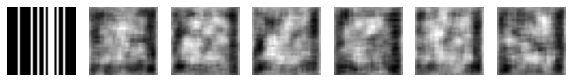

Epoch 31 gen_loss=1.060 disc_loss=0.530 real_acc=0.84 fake_acc=1.0
Epoch 32 gen_loss=1.061 disc_loss=0.522 real_acc=0.94 fake_acc=1.0
Epoch 33 gen_loss=1.071 disc_loss=0.528 real_acc=0.82 fake_acc=1.0
Epoch 34 gen_loss=1.054 disc_loss=0.531 real_acc=0.86 fake_acc=1.0
Epoch 35 gen_loss=1.103 disc_loss=0.527 real_acc=0.72 fake_acc=1.0
Epoch 36 gen_loss=1.124 disc_loss=0.515 real_acc=0.78 fake_acc=1.0
Epoch 37 gen_loss=1.156 disc_loss=0.505 real_acc=0.8 fake_acc=1.0
Epoch 38 gen_loss=1.207 disc_loss=0.489 real_acc=0.86 fake_acc=1.0
Epoch 39 gen_loss=1.235 disc_loss=0.486 real_acc=0.82 fake_acc=1.0
Epoch 40 gen_loss=1.269 disc_loss=0.490 real_acc=0.76 fake_acc=1.0


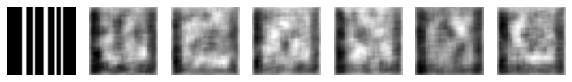

Epoch 41 gen_loss=1.302 disc_loss=0.476 real_acc=0.78 fake_acc=1.0
Epoch 42 gen_loss=1.311 disc_loss=0.474 real_acc=0.84 fake_acc=1.0
Epoch 43 gen_loss=1.331 disc_loss=0.475 real_acc=0.74 fake_acc=1.0
Epoch 44 gen_loss=1.348 disc_loss=0.449 real_acc=0.92 fake_acc=1.0
Epoch 45 gen_loss=1.347 disc_loss=0.446 real_acc=0.94 fake_acc=1.0
Epoch 46 gen_loss=1.309 disc_loss=0.439 real_acc=0.92 fake_acc=1.0
Epoch 47 gen_loss=1.318 disc_loss=0.423 real_acc=0.96 fake_acc=1.0
Epoch 48 gen_loss=1.304 disc_loss=0.436 real_acc=0.9 fake_acc=1.0
Epoch 49 gen_loss=1.299 disc_loss=0.422 real_acc=0.96 fake_acc=1.0
Epoch 50 gen_loss=1.279 disc_loss=0.408 real_acc=0.96 fake_acc=1.0


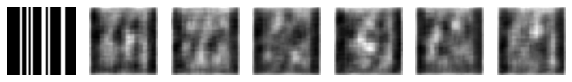

Epoch 51 gen_loss=1.281 disc_loss=0.418 real_acc=0.98 fake_acc=1.0
Epoch 52 gen_loss=1.262 disc_loss=0.399 real_acc=1.0 fake_acc=1.0
Epoch 53 gen_loss=1.239 disc_loss=0.418 real_acc=0.9 fake_acc=1.0
Epoch 54 gen_loss=1.224 disc_loss=0.409 real_acc=0.98 fake_acc=1.0
Epoch 55 gen_loss=1.226 disc_loss=0.408 real_acc=0.98 fake_acc=1.0
Epoch 56 gen_loss=1.261 disc_loss=0.391 real_acc=0.98 fake_acc=1.0
Epoch 57 gen_loss=1.289 disc_loss=0.400 real_acc=0.96 fake_acc=1.0
Epoch 58 gen_loss=1.286 disc_loss=0.412 real_acc=0.92 fake_acc=1.0
Epoch 59 gen_loss=1.311 disc_loss=0.378 real_acc=0.94 fake_acc=1.0
Epoch 60 gen_loss=1.302 disc_loss=0.393 real_acc=0.9 fake_acc=1.0


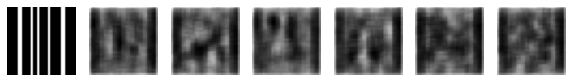

Epoch 61 gen_loss=1.322 disc_loss=0.361 real_acc=0.98 fake_acc=1.0
Epoch 62 gen_loss=1.345 disc_loss=0.385 real_acc=0.94 fake_acc=1.0
Epoch 63 gen_loss=1.318 disc_loss=0.377 real_acc=0.92 fake_acc=1.0
Epoch 64 gen_loss=1.329 disc_loss=0.388 real_acc=0.92 fake_acc=1.0
Epoch 65 gen_loss=1.311 disc_loss=0.388 real_acc=0.9 fake_acc=1.0
Epoch 66 gen_loss=1.354 disc_loss=0.373 real_acc=0.92 fake_acc=1.0
Epoch 67 gen_loss=1.322 disc_loss=0.366 real_acc=0.98 fake_acc=1.0
Epoch 68 gen_loss=1.240 disc_loss=0.364 real_acc=0.94 fake_acc=1.0
Epoch 69 gen_loss=1.206 disc_loss=0.366 real_acc=0.96 fake_acc=1.0
Epoch 70 gen_loss=1.250 disc_loss=0.355 real_acc=0.98 fake_acc=1.0


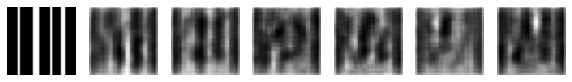

Epoch 71 gen_loss=1.244 disc_loss=0.354 real_acc=0.98 fake_acc=1.0
Epoch 72 gen_loss=1.348 disc_loss=0.335 real_acc=0.98 fake_acc=1.0
Epoch 73 gen_loss=1.382 disc_loss=0.311 real_acc=0.98 fake_acc=1.0
Epoch 74 gen_loss=1.391 disc_loss=0.347 real_acc=0.96 fake_acc=1.0
Epoch 75 gen_loss=1.429 disc_loss=0.310 real_acc=0.98 fake_acc=1.0
Epoch 76 gen_loss=1.467 disc_loss=0.322 real_acc=0.98 fake_acc=1.0
Epoch 77 gen_loss=1.451 disc_loss=0.325 real_acc=0.94 fake_acc=1.0
Epoch 78 gen_loss=1.457 disc_loss=0.289 real_acc=1.0 fake_acc=0.98
Epoch 79 gen_loss=1.369 disc_loss=0.296 real_acc=1.0 fake_acc=1.0
Epoch 80 gen_loss=1.422 disc_loss=0.283 real_acc=1.0 fake_acc=1.0


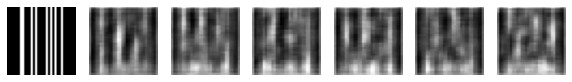

Epoch 81 gen_loss=1.423 disc_loss=0.287 real_acc=1.0 fake_acc=1.0
Epoch 82 gen_loss=1.441 disc_loss=0.269 real_acc=1.0 fake_acc=1.0
Epoch 83 gen_loss=1.492 disc_loss=0.273 real_acc=0.98 fake_acc=1.0
Epoch 84 gen_loss=1.514 disc_loss=0.263 real_acc=1.0 fake_acc=1.0
Epoch 85 gen_loss=1.493 disc_loss=0.255 real_acc=1.0 fake_acc=1.0
Epoch 86 gen_loss=1.595 disc_loss=0.228 real_acc=1.0 fake_acc=1.0
Epoch 87 gen_loss=1.579 disc_loss=0.251 real_acc=0.98 fake_acc=1.0
Epoch 88 gen_loss=1.603 disc_loss=0.248 real_acc=1.0 fake_acc=1.0
Epoch 89 gen_loss=1.531 disc_loss=0.260 real_acc=0.96 fake_acc=1.0
Epoch 90 gen_loss=1.566 disc_loss=0.233 real_acc=1.0 fake_acc=1.0


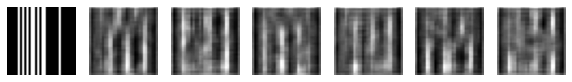

Epoch 91 gen_loss=1.501 disc_loss=0.233 real_acc=1.0 fake_acc=1.0
Epoch 92 gen_loss=1.440 disc_loss=0.234 real_acc=1.0 fake_acc=0.98
Epoch 93 gen_loss=1.498 disc_loss=0.237 real_acc=1.0 fake_acc=1.0
Epoch 94 gen_loss=1.523 disc_loss=0.223 real_acc=1.0 fake_acc=1.0
Epoch 95 gen_loss=1.496 disc_loss=0.247 real_acc=0.94 fake_acc=1.0
Epoch 96 gen_loss=1.538 disc_loss=0.228 real_acc=1.0 fake_acc=1.0
Epoch 97 gen_loss=1.598 disc_loss=0.241 real_acc=0.94 fake_acc=1.0
Epoch 98 gen_loss=1.518 disc_loss=0.261 real_acc=0.92 fake_acc=1.0
Epoch 99 gen_loss=1.518 disc_loss=0.256 real_acc=0.94 fake_acc=1.0
Epoch 100 gen_loss=1.510 disc_loss=0.247 real_acc=0.98 fake_acc=1.0


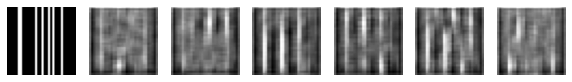

Epoch 101 gen_loss=1.394 disc_loss=0.249 real_acc=0.96 fake_acc=1.0
Epoch 102 gen_loss=1.366 disc_loss=0.227 real_acc=1.0 fake_acc=1.0
Epoch 103 gen_loss=1.371 disc_loss=0.235 real_acc=0.98 fake_acc=1.0
Epoch 104 gen_loss=1.404 disc_loss=0.232 real_acc=0.98 fake_acc=1.0
Epoch 105 gen_loss=1.454 disc_loss=0.233 real_acc=0.94 fake_acc=1.0
Epoch 106 gen_loss=1.495 disc_loss=0.265 real_acc=0.94 fake_acc=1.0
Epoch 107 gen_loss=1.489 disc_loss=0.302 real_acc=0.86 fake_acc=1.0
Epoch 108 gen_loss=1.410 disc_loss=0.295 real_acc=0.9 fake_acc=1.0
Epoch 109 gen_loss=1.386 disc_loss=0.270 real_acc=0.98 fake_acc=1.0
Epoch 110 gen_loss=1.304 disc_loss=0.269 real_acc=0.96 fake_acc=0.98


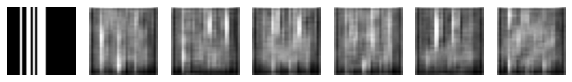

Epoch 111 gen_loss=1.221 disc_loss=0.308 real_acc=0.9 fake_acc=1.0
Epoch 112 gen_loss=1.204 disc_loss=0.263 real_acc=1.0 fake_acc=0.96
Epoch 113 gen_loss=1.192 disc_loss=0.318 real_acc=0.9 fake_acc=1.0
Epoch 114 gen_loss=1.214 disc_loss=0.282 real_acc=0.94 fake_acc=0.9
Epoch 115 gen_loss=1.306 disc_loss=0.309 real_acc=0.92 fake_acc=0.98
Epoch 116 gen_loss=1.235 disc_loss=0.332 real_acc=0.9 fake_acc=0.96
Epoch 117 gen_loss=1.351 disc_loss=0.292 real_acc=0.86 fake_acc=0.96
Epoch 118 gen_loss=1.285 disc_loss=0.310 real_acc=0.84 fake_acc=0.98
Epoch 119 gen_loss=1.264 disc_loss=0.328 real_acc=0.88 fake_acc=0.98
Epoch 120 gen_loss=1.196 disc_loss=0.381 real_acc=0.8 fake_acc=0.98


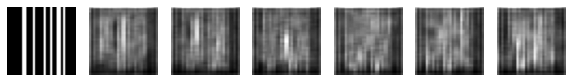

Epoch 121 gen_loss=1.138 disc_loss=0.374 real_acc=0.82 fake_acc=0.96
Epoch 122 gen_loss=1.110 disc_loss=0.380 real_acc=0.88 fake_acc=0.88
Epoch 123 gen_loss=0.996 disc_loss=0.404 real_acc=0.82 fake_acc=0.78
Epoch 124 gen_loss=0.960 disc_loss=0.477 real_acc=0.82 fake_acc=0.78
Epoch 125 gen_loss=0.879 disc_loss=0.446 real_acc=0.84 fake_acc=0.74
Epoch 126 gen_loss=0.824 disc_loss=0.456 real_acc=0.9 fake_acc=0.68
Epoch 127 gen_loss=0.876 disc_loss=0.466 real_acc=0.82 fake_acc=0.7
Epoch 128 gen_loss=0.820 disc_loss=0.524 real_acc=0.82 fake_acc=0.58
Epoch 129 gen_loss=0.864 disc_loss=0.484 real_acc=0.8 fake_acc=0.76
Epoch 130 gen_loss=0.790 disc_loss=0.491 real_acc=0.84 fake_acc=0.58


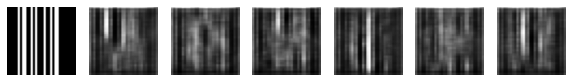

Epoch 131 gen_loss=0.824 disc_loss=0.494 real_acc=0.86 fake_acc=0.66
Epoch 132 gen_loss=0.828 disc_loss=0.465 real_acc=0.88 fake_acc=0.76
Epoch 133 gen_loss=0.929 disc_loss=0.405 real_acc=0.92 fake_acc=0.8
Epoch 134 gen_loss=1.015 disc_loss=0.414 real_acc=0.86 fake_acc=0.88
Epoch 135 gen_loss=1.041 disc_loss=0.384 real_acc=0.9 fake_acc=0.92
Epoch 136 gen_loss=1.070 disc_loss=0.343 real_acc=0.96 fake_acc=0.98
Epoch 137 gen_loss=1.078 disc_loss=0.352 real_acc=0.96 fake_acc=0.92
Epoch 138 gen_loss=1.125 disc_loss=0.305 real_acc=0.96 fake_acc=1.0
Epoch 139 gen_loss=1.154 disc_loss=0.295 real_acc=0.98 fake_acc=0.92
Epoch 140 gen_loss=1.231 disc_loss=0.256 real_acc=1.0 fake_acc=0.96


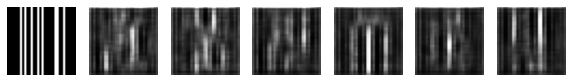

Epoch 141 gen_loss=1.319 disc_loss=0.251 real_acc=0.94 fake_acc=1.0
Epoch 142 gen_loss=1.303 disc_loss=0.244 real_acc=0.98 fake_acc=1.0
Epoch 143 gen_loss=1.399 disc_loss=0.243 real_acc=0.96 fake_acc=1.0
Epoch 144 gen_loss=1.381 disc_loss=0.204 real_acc=1.0 fake_acc=1.0
Epoch 145 gen_loss=1.477 disc_loss=0.214 real_acc=0.94 fake_acc=1.0
Epoch 146 gen_loss=1.470 disc_loss=0.205 real_acc=0.96 fake_acc=1.0
Epoch 147 gen_loss=1.539 disc_loss=0.212 real_acc=0.98 fake_acc=1.0
Epoch 148 gen_loss=1.554 disc_loss=0.242 real_acc=0.9 fake_acc=1.0
Epoch 149 gen_loss=1.556 disc_loss=0.182 real_acc=0.98 fake_acc=1.0
Epoch 150 gen_loss=1.586 disc_loss=0.221 real_acc=0.94 fake_acc=1.0


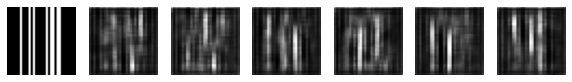

Epoch 151 gen_loss=1.507 disc_loss=0.188 real_acc=1.0 fake_acc=1.0
Epoch 152 gen_loss=1.503 disc_loss=0.177 real_acc=1.0 fake_acc=1.0
Epoch 153 gen_loss=1.564 disc_loss=0.188 real_acc=0.98 fake_acc=1.0
Epoch 154 gen_loss=1.544 disc_loss=0.154 real_acc=1.0 fake_acc=1.0
Epoch 155 gen_loss=1.552 disc_loss=0.161 real_acc=1.0 fake_acc=1.0
Epoch 156 gen_loss=1.608 disc_loss=0.168 real_acc=0.96 fake_acc=1.0
Epoch 157 gen_loss=1.697 disc_loss=0.156 real_acc=0.96 fake_acc=1.0
Epoch 158 gen_loss=1.713 disc_loss=0.198 real_acc=0.94 fake_acc=1.0
Epoch 159 gen_loss=1.597 disc_loss=0.221 real_acc=0.92 fake_acc=1.0
Epoch 160 gen_loss=1.480 disc_loss=0.266 real_acc=0.9 fake_acc=1.0


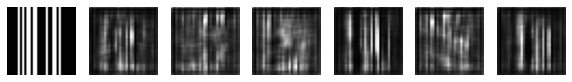

Epoch 161 gen_loss=1.379 disc_loss=0.220 real_acc=0.96 fake_acc=0.98
Epoch 162 gen_loss=1.267 disc_loss=0.305 real_acc=0.92 fake_acc=0.98
Epoch 163 gen_loss=1.207 disc_loss=0.288 real_acc=0.94 fake_acc=0.94
Epoch 164 gen_loss=1.120 disc_loss=0.383 real_acc=0.86 fake_acc=0.88
Epoch 165 gen_loss=1.072 disc_loss=0.418 real_acc=0.86 fake_acc=0.78
Epoch 166 gen_loss=1.047 disc_loss=0.445 real_acc=0.8 fake_acc=0.76
Epoch 167 gen_loss=0.937 disc_loss=0.486 real_acc=0.9 fake_acc=0.64
Epoch 168 gen_loss=0.996 disc_loss=0.465 real_acc=0.86 fake_acc=0.68
Epoch 169 gen_loss=1.024 disc_loss=0.399 real_acc=0.88 fake_acc=0.74
Epoch 170 gen_loss=1.070 disc_loss=0.501 real_acc=0.82 fake_acc=0.66


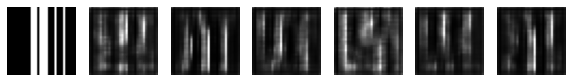

Epoch 171 gen_loss=1.066 disc_loss=0.468 real_acc=0.82 fake_acc=0.78
Epoch 172 gen_loss=1.060 disc_loss=0.448 real_acc=0.8 fake_acc=0.8
Epoch 173 gen_loss=1.143 disc_loss=0.447 real_acc=0.8 fake_acc=0.78
Epoch 174 gen_loss=1.304 disc_loss=0.327 real_acc=0.92 fake_acc=0.78
Epoch 175 gen_loss=1.251 disc_loss=0.465 real_acc=0.72 fake_acc=0.9
Epoch 176 gen_loss=1.239 disc_loss=0.421 real_acc=0.82 fake_acc=0.86
Epoch 177 gen_loss=1.117 disc_loss=0.340 real_acc=0.96 fake_acc=0.86
Epoch 178 gen_loss=1.161 disc_loss=0.343 real_acc=0.9 fake_acc=0.9
Epoch 179 gen_loss=1.194 disc_loss=0.320 real_acc=0.94 fake_acc=0.82
Epoch 180 gen_loss=1.177 disc_loss=0.279 real_acc=0.98 fake_acc=0.9


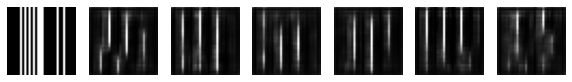

Epoch 181 gen_loss=1.308 disc_loss=0.241 real_acc=0.96 fake_acc=0.96
Epoch 182 gen_loss=1.418 disc_loss=0.233 real_acc=0.98 fake_acc=0.96
Epoch 183 gen_loss=1.644 disc_loss=0.208 real_acc=0.9 fake_acc=1.0
Epoch 184 gen_loss=1.825 disc_loss=0.194 real_acc=0.92 fake_acc=1.0
Epoch 185 gen_loss=1.873 disc_loss=0.143 real_acc=0.98 fake_acc=0.98
Epoch 186 gen_loss=1.912 disc_loss=0.184 real_acc=0.92 fake_acc=1.0
Epoch 187 gen_loss=2.068 disc_loss=0.162 real_acc=0.96 fake_acc=1.0
Epoch 188 gen_loss=2.040 disc_loss=0.163 real_acc=0.94 fake_acc=1.0
Epoch 189 gen_loss=2.076 disc_loss=0.143 real_acc=0.98 fake_acc=1.0
Epoch 190 gen_loss=2.027 disc_loss=0.136 real_acc=0.98 fake_acc=1.0


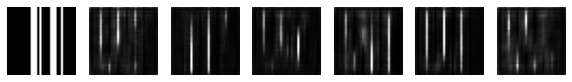

Epoch 191 gen_loss=1.992 disc_loss=0.127 real_acc=0.96 fake_acc=1.0
Epoch 192 gen_loss=2.092 disc_loss=0.110 real_acc=0.96 fake_acc=1.0
Epoch 193 gen_loss=2.033 disc_loss=0.105 real_acc=0.98 fake_acc=1.0
Epoch 194 gen_loss=2.070 disc_loss=0.167 real_acc=0.9 fake_acc=1.0
Epoch 195 gen_loss=1.965 disc_loss=0.134 real_acc=0.96 fake_acc=1.0
Epoch 196 gen_loss=1.959 disc_loss=0.096 real_acc=1.0 fake_acc=1.0
Epoch 197 gen_loss=1.956 disc_loss=0.103 real_acc=1.0 fake_acc=1.0
Epoch 198 gen_loss=1.934 disc_loss=0.109 real_acc=1.0 fake_acc=1.0
Epoch 199 gen_loss=2.031 disc_loss=0.091 real_acc=1.0 fake_acc=1.0
Epoch 200 gen_loss=1.997 disc_loss=0.115 real_acc=0.96 fake_acc=1.0


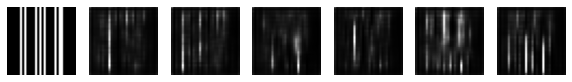

Epoch 201 gen_loss=2.052 disc_loss=0.101 real_acc=0.98 fake_acc=1.0
Epoch 202 gen_loss=2.123 disc_loss=0.137 real_acc=0.96 fake_acc=1.0
Epoch 203 gen_loss=2.306 disc_loss=0.094 real_acc=0.98 fake_acc=1.0
Epoch 204 gen_loss=2.177 disc_loss=0.155 real_acc=0.94 fake_acc=1.0
Epoch 205 gen_loss=2.149 disc_loss=0.170 real_acc=0.94 fake_acc=1.0
Epoch 206 gen_loss=2.083 disc_loss=0.165 real_acc=0.96 fake_acc=1.0
Epoch 207 gen_loss=2.049 disc_loss=0.101 real_acc=1.0 fake_acc=1.0
Epoch 208 gen_loss=2.001 disc_loss=0.156 real_acc=0.92 fake_acc=1.0
Epoch 209 gen_loss=2.036 disc_loss=0.284 real_acc=0.8 fake_acc=0.94
Epoch 210 gen_loss=1.700 disc_loss=0.244 real_acc=0.92 fake_acc=0.98


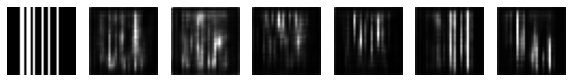

Epoch 211 gen_loss=1.629 disc_loss=0.251 real_acc=0.92 fake_acc=0.96
Epoch 212 gen_loss=1.425 disc_loss=0.297 real_acc=0.94 fake_acc=0.9
Epoch 213 gen_loss=1.409 disc_loss=0.328 real_acc=0.9 fake_acc=0.86
Epoch 214 gen_loss=1.289 disc_loss=0.324 real_acc=0.96 fake_acc=0.78
Epoch 215 gen_loss=1.428 disc_loss=0.272 real_acc=0.9 fake_acc=0.84
Epoch 216 gen_loss=1.231 disc_loss=0.383 real_acc=0.88 fake_acc=0.74
Epoch 217 gen_loss=1.626 disc_loss=0.288 real_acc=0.86 fake_acc=0.9
Epoch 218 gen_loss=1.723 disc_loss=0.498 real_acc=0.7 fake_acc=0.96
Epoch 219 gen_loss=1.734 disc_loss=0.442 real_acc=0.76 fake_acc=0.86
Epoch 220 gen_loss=1.742 disc_loss=0.364 real_acc=0.78 fake_acc=0.96


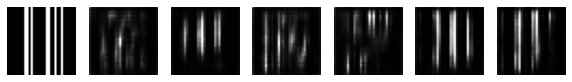

Epoch 221 gen_loss=1.622 disc_loss=0.391 real_acc=0.78 fake_acc=0.94
Epoch 222 gen_loss=1.587 disc_loss=0.258 real_acc=0.94 fake_acc=0.86
Epoch 223 gen_loss=1.291 disc_loss=0.452 real_acc=0.82 fake_acc=0.86
Epoch 224 gen_loss=1.231 disc_loss=0.398 real_acc=0.86 fake_acc=0.86
Epoch 225 gen_loss=1.152 disc_loss=0.428 real_acc=0.84 fake_acc=0.7
Epoch 226 gen_loss=1.221 disc_loss=0.389 real_acc=0.92 fake_acc=0.8
Epoch 227 gen_loss=1.132 disc_loss=0.452 real_acc=0.88 fake_acc=0.6
Epoch 228 gen_loss=1.261 disc_loss=0.424 real_acc=0.82 fake_acc=0.8
Epoch 229 gen_loss=1.330 disc_loss=0.448 real_acc=0.78 fake_acc=0.8
Epoch 230 gen_loss=1.499 disc_loss=0.408 real_acc=0.82 fake_acc=0.76


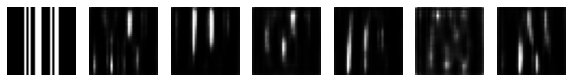

Epoch 231 gen_loss=1.465 disc_loss=0.424 real_acc=0.84 fake_acc=0.8
Epoch 232 gen_loss=1.540 disc_loss=0.404 real_acc=0.8 fake_acc=0.8
Epoch 233 gen_loss=1.573 disc_loss=0.496 real_acc=0.72 fake_acc=0.78
Epoch 234 gen_loss=1.629 disc_loss=0.483 real_acc=0.7 fake_acc=0.76
Epoch 235 gen_loss=1.800 disc_loss=0.412 real_acc=0.72 fake_acc=0.86
Epoch 236 gen_loss=1.571 disc_loss=0.435 real_acc=0.84 fake_acc=0.78
Epoch 237 gen_loss=1.687 disc_loss=0.372 real_acc=0.82 fake_acc=0.88
Epoch 238 gen_loss=1.638 disc_loss=0.285 real_acc=0.92 fake_acc=0.84
Epoch 239 gen_loss=1.470 disc_loss=0.404 real_acc=0.84 fake_acc=0.72
Epoch 240 gen_loss=1.790 disc_loss=0.290 real_acc=0.9 fake_acc=0.88


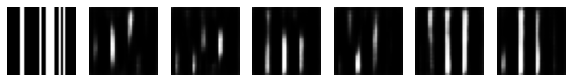

Epoch 241 gen_loss=1.634 disc_loss=0.335 real_acc=0.88 fake_acc=0.84
Epoch 242 gen_loss=1.721 disc_loss=0.251 real_acc=0.92 fake_acc=0.92
Epoch 243 gen_loss=1.715 disc_loss=0.237 real_acc=0.94 fake_acc=0.92
Epoch 244 gen_loss=1.919 disc_loss=0.196 real_acc=0.98 fake_acc=0.9
Epoch 245 gen_loss=2.136 disc_loss=0.193 real_acc=0.94 fake_acc=0.92
Epoch 246 gen_loss=2.129 disc_loss=0.196 real_acc=0.96 fake_acc=0.98
Epoch 247 gen_loss=2.172 disc_loss=0.196 real_acc=0.88 fake_acc=0.98
Epoch 248 gen_loss=2.273 disc_loss=0.174 real_acc=0.86 fake_acc=1.0
Epoch 249 gen_loss=2.458 disc_loss=0.120 real_acc=1.0 fake_acc=1.0
Epoch 250 gen_loss=2.419 disc_loss=0.120 real_acc=0.98 fake_acc=1.0


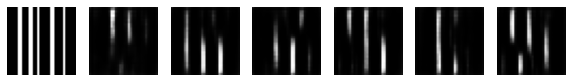

Epoch 251 gen_loss=2.532 disc_loss=0.124 real_acc=0.98 fake_acc=0.98
Epoch 252 gen_loss=2.541 disc_loss=0.146 real_acc=0.98 fake_acc=1.0
Epoch 253 gen_loss=2.599 disc_loss=0.121 real_acc=0.96 fake_acc=1.0
Epoch 254 gen_loss=2.416 disc_loss=0.162 real_acc=0.92 fake_acc=1.0
Epoch 255 gen_loss=2.329 disc_loss=0.097 real_acc=1.0 fake_acc=1.0
Epoch 256 gen_loss=2.152 disc_loss=0.108 real_acc=1.0 fake_acc=1.0
Epoch 257 gen_loss=2.349 disc_loss=0.124 real_acc=0.94 fake_acc=0.98
Epoch 258 gen_loss=2.259 disc_loss=0.094 real_acc=1.0 fake_acc=1.0
Epoch 259 gen_loss=2.337 disc_loss=0.090 real_acc=0.98 fake_acc=1.0
Epoch 260 gen_loss=2.260 disc_loss=0.110 real_acc=0.98 fake_acc=1.0


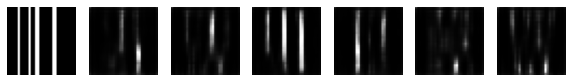

Epoch 261 gen_loss=2.325 disc_loss=0.104 real_acc=0.98 fake_acc=1.0
Epoch 262 gen_loss=2.548 disc_loss=0.068 real_acc=1.0 fake_acc=1.0
Epoch 263 gen_loss=2.574 disc_loss=0.082 real_acc=0.98 fake_acc=1.0
Epoch 264 gen_loss=2.726 disc_loss=0.071 real_acc=0.98 fake_acc=1.0
Epoch 265 gen_loss=2.733 disc_loss=0.072 real_acc=1.0 fake_acc=1.0
Epoch 266 gen_loss=2.855 disc_loss=0.069 real_acc=0.98 fake_acc=1.0
Epoch 267 gen_loss=2.930 disc_loss=0.071 real_acc=1.0 fake_acc=1.0
Epoch 268 gen_loss=2.792 disc_loss=0.073 real_acc=0.98 fake_acc=1.0
Epoch 269 gen_loss=2.860 disc_loss=0.088 real_acc=0.96 fake_acc=1.0
Epoch 270 gen_loss=2.692 disc_loss=0.101 real_acc=0.96 fake_acc=1.0


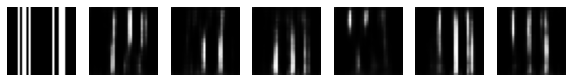

Epoch 271 gen_loss=2.618 disc_loss=0.097 real_acc=0.96 fake_acc=1.0
Epoch 272 gen_loss=2.600 disc_loss=0.110 real_acc=0.98 fake_acc=1.0
Epoch 273 gen_loss=2.587 disc_loss=0.090 real_acc=1.0 fake_acc=0.98
Epoch 274 gen_loss=2.433 disc_loss=0.119 real_acc=0.98 fake_acc=0.98
Epoch 275 gen_loss=2.571 disc_loss=0.139 real_acc=0.94 fake_acc=1.0
Epoch 276 gen_loss=2.627 disc_loss=0.126 real_acc=0.96 fake_acc=1.0
Epoch 277 gen_loss=2.424 disc_loss=0.095 real_acc=1.0 fake_acc=1.0
Epoch 278 gen_loss=2.351 disc_loss=0.130 real_acc=1.0 fake_acc=0.98
Epoch 279 gen_loss=2.235 disc_loss=0.159 real_acc=0.96 fake_acc=0.98
Epoch 280 gen_loss=2.428 disc_loss=0.177 real_acc=0.94 fake_acc=0.92


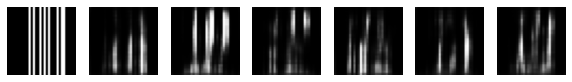

Epoch 281 gen_loss=2.353 disc_loss=0.154 real_acc=0.94 fake_acc=0.98
Epoch 282 gen_loss=2.651 disc_loss=0.226 real_acc=0.84 fake_acc=1.0
Epoch 283 gen_loss=2.648 disc_loss=0.165 real_acc=0.94 fake_acc=1.0
Epoch 284 gen_loss=2.663 disc_loss=0.176 real_acc=0.92 fake_acc=0.96
Epoch 285 gen_loss=2.410 disc_loss=0.210 real_acc=0.9 fake_acc=0.92
Epoch 286 gen_loss=2.256 disc_loss=0.232 real_acc=0.88 fake_acc=0.94
Epoch 287 gen_loss=2.148 disc_loss=0.276 real_acc=0.88 fake_acc=0.9
Epoch 288 gen_loss=2.336 disc_loss=0.154 real_acc=0.94 fake_acc=0.98
Epoch 289 gen_loss=2.340 disc_loss=0.207 real_acc=0.88 fake_acc=0.94
Epoch 290 gen_loss=2.113 disc_loss=0.173 real_acc=0.96 fake_acc=0.94


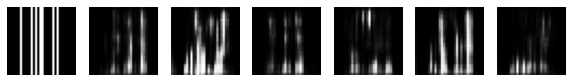

Epoch 291 gen_loss=2.215 disc_loss=0.176 real_acc=0.96 fake_acc=0.96
Epoch 292 gen_loss=2.276 disc_loss=0.198 real_acc=0.96 fake_acc=0.9
Epoch 293 gen_loss=2.626 disc_loss=0.185 real_acc=0.9 fake_acc=0.98
Epoch 294 gen_loss=2.710 disc_loss=0.187 real_acc=0.88 fake_acc=0.96
Epoch 295 gen_loss=2.919 disc_loss=0.251 real_acc=0.84 fake_acc=1.0
Epoch 296 gen_loss=2.563 disc_loss=0.199 real_acc=0.88 fake_acc=0.96
Epoch 297 gen_loss=2.559 disc_loss=0.227 real_acc=0.86 fake_acc=0.98
Epoch 298 gen_loss=2.247 disc_loss=0.261 real_acc=0.86 fake_acc=0.96
Epoch 299 gen_loss=1.978 disc_loss=0.249 real_acc=0.92 fake_acc=0.88
Epoch 300 gen_loss=1.994 disc_loss=0.235 real_acc=0.9 fake_acc=0.94


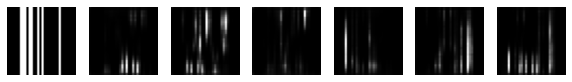

Epoch 301 gen_loss=1.784 disc_loss=0.284 real_acc=0.94 fake_acc=0.88
Epoch 302 gen_loss=1.837 disc_loss=0.299 real_acc=0.88 fake_acc=0.86
Epoch 303 gen_loss=2.009 disc_loss=0.271 real_acc=0.84 fake_acc=0.86
Epoch 304 gen_loss=2.140 disc_loss=0.215 real_acc=0.9 fake_acc=0.96
Epoch 305 gen_loss=2.528 disc_loss=0.270 real_acc=0.82 fake_acc=1.0
Epoch 306 gen_loss=2.493 disc_loss=0.296 real_acc=0.84 fake_acc=0.96
Epoch 307 gen_loss=2.299 disc_loss=0.236 real_acc=0.82 fake_acc=0.98
Epoch 308 gen_loss=2.038 disc_loss=0.275 real_acc=0.9 fake_acc=0.92
Epoch 309 gen_loss=1.962 disc_loss=0.225 real_acc=0.9 fake_acc=0.94
Epoch 310 gen_loss=1.628 disc_loss=0.287 real_acc=0.92 fake_acc=0.86


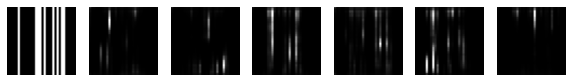

Epoch 311 gen_loss=1.896 disc_loss=0.252 real_acc=0.94 fake_acc=0.9
Epoch 312 gen_loss=1.962 disc_loss=0.236 real_acc=0.9 fake_acc=0.92
Epoch 313 gen_loss=2.284 disc_loss=0.308 real_acc=0.84 fake_acc=0.94
Epoch 314 gen_loss=2.240 disc_loss=0.235 real_acc=0.88 fake_acc=0.98
Epoch 315 gen_loss=2.212 disc_loss=0.196 real_acc=0.92 fake_acc=1.0
Epoch 316 gen_loss=2.233 disc_loss=0.227 real_acc=0.9 fake_acc=0.96
Epoch 317 gen_loss=2.241 disc_loss=0.165 real_acc=1.0 fake_acc=0.98
Epoch 318 gen_loss=2.412 disc_loss=0.194 real_acc=0.88 fake_acc=0.96
Epoch 319 gen_loss=2.198 disc_loss=0.151 real_acc=0.98 fake_acc=0.92
Epoch 320 gen_loss=2.244 disc_loss=0.182 real_acc=0.96 fake_acc=0.96


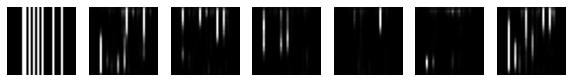

Epoch 321 gen_loss=2.118 disc_loss=0.171 real_acc=0.98 fake_acc=0.98
Epoch 322 gen_loss=2.262 disc_loss=0.167 real_acc=0.94 fake_acc=0.98
Epoch 323 gen_loss=2.447 disc_loss=0.235 real_acc=0.84 fake_acc=0.96
Epoch 324 gen_loss=2.265 disc_loss=0.155 real_acc=0.94 fake_acc=0.98
Epoch 325 gen_loss=2.333 disc_loss=0.160 real_acc=0.96 fake_acc=0.98
Epoch 326 gen_loss=2.349 disc_loss=0.201 real_acc=0.86 fake_acc=0.98
Epoch 327 gen_loss=2.456 disc_loss=0.149 real_acc=0.94 fake_acc=1.0
Epoch 328 gen_loss=2.220 disc_loss=0.145 real_acc=0.96 fake_acc=0.98
Epoch 329 gen_loss=2.175 disc_loss=0.192 real_acc=0.94 fake_acc=0.96
Epoch 330 gen_loss=2.279 disc_loss=0.190 real_acc=0.92 fake_acc=0.98


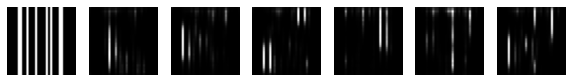

Epoch 331 gen_loss=2.331 disc_loss=0.170 real_acc=0.94 fake_acc=0.98
Epoch 332 gen_loss=2.289 disc_loss=0.119 real_acc=0.98 fake_acc=1.0
Epoch 333 gen_loss=2.296 disc_loss=0.162 real_acc=0.94 fake_acc=0.96
Epoch 334 gen_loss=2.430 disc_loss=0.121 real_acc=1.0 fake_acc=1.0
Epoch 335 gen_loss=2.433 disc_loss=0.193 real_acc=0.88 fake_acc=0.98
Epoch 336 gen_loss=2.500 disc_loss=0.135 real_acc=0.96 fake_acc=1.0
Epoch 337 gen_loss=2.315 disc_loss=0.202 real_acc=0.86 fake_acc=1.0
Epoch 338 gen_loss=2.207 disc_loss=0.185 real_acc=0.9 fake_acc=0.96
Epoch 339 gen_loss=2.153 disc_loss=0.163 real_acc=0.96 fake_acc=0.94
Epoch 340 gen_loss=2.310 disc_loss=0.157 real_acc=0.94 fake_acc=0.96


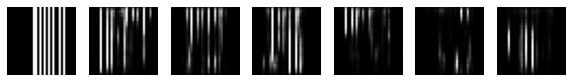

Epoch 341 gen_loss=2.354 disc_loss=0.193 real_acc=0.9 fake_acc=0.96
Epoch 342 gen_loss=2.393 disc_loss=0.154 real_acc=0.96 fake_acc=0.98
Epoch 343 gen_loss=2.615 disc_loss=0.133 real_acc=0.94 fake_acc=0.98
Epoch 344 gen_loss=2.575 disc_loss=0.140 real_acc=0.94 fake_acc=1.0
Epoch 345 gen_loss=2.861 disc_loss=0.199 real_acc=0.84 fake_acc=0.98
Epoch 346 gen_loss=2.772 disc_loss=0.155 real_acc=0.92 fake_acc=1.0
Epoch 347 gen_loss=2.633 disc_loss=0.116 real_acc=1.0 fake_acc=1.0
Epoch 348 gen_loss=2.491 disc_loss=0.170 real_acc=0.92 fake_acc=0.96
Epoch 349 gen_loss=2.087 disc_loss=0.216 real_acc=0.88 fake_acc=0.96
Epoch 350 gen_loss=2.310 disc_loss=0.154 real_acc=0.94 fake_acc=0.96


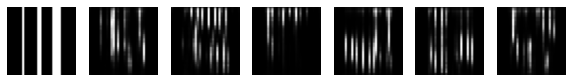

Epoch 351 gen_loss=2.134 disc_loss=0.183 real_acc=0.9 fake_acc=0.98
Epoch 352 gen_loss=2.308 disc_loss=0.176 real_acc=0.96 fake_acc=0.98
Epoch 353 gen_loss=2.286 disc_loss=0.129 real_acc=1.0 fake_acc=0.98
Epoch 354 gen_loss=2.577 disc_loss=0.166 real_acc=0.92 fake_acc=1.0
Epoch 355 gen_loss=2.500 disc_loss=0.199 real_acc=0.88 fake_acc=0.98
Epoch 356 gen_loss=2.513 disc_loss=0.172 real_acc=0.86 fake_acc=1.0
Epoch 357 gen_loss=2.530 disc_loss=0.163 real_acc=0.92 fake_acc=1.0
Epoch 358 gen_loss=2.335 disc_loss=0.198 real_acc=0.9 fake_acc=0.98
Epoch 359 gen_loss=2.406 disc_loss=0.165 real_acc=0.92 fake_acc=0.98
Epoch 360 gen_loss=2.355 disc_loss=0.231 real_acc=0.88 fake_acc=0.98


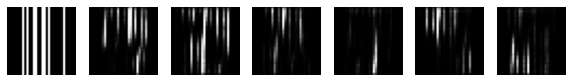

Epoch 361 gen_loss=2.112 disc_loss=0.198 real_acc=0.94 fake_acc=0.98
Epoch 362 gen_loss=2.219 disc_loss=0.177 real_acc=0.96 fake_acc=0.94
Epoch 363 gen_loss=2.120 disc_loss=0.220 real_acc=0.9 fake_acc=0.94
Epoch 364 gen_loss=2.100 disc_loss=0.224 real_acc=0.94 fake_acc=0.94
Epoch 365 gen_loss=2.188 disc_loss=0.157 real_acc=0.98 fake_acc=0.96
Epoch 366 gen_loss=2.210 disc_loss=0.231 real_acc=0.92 fake_acc=0.98
Epoch 367 gen_loss=2.395 disc_loss=0.233 real_acc=0.86 fake_acc=0.96
Epoch 368 gen_loss=2.518 disc_loss=0.223 real_acc=0.88 fake_acc=0.98
Epoch 369 gen_loss=2.284 disc_loss=0.239 real_acc=0.9 fake_acc=0.94
Epoch 370 gen_loss=1.978 disc_loss=0.215 real_acc=0.96 fake_acc=0.92


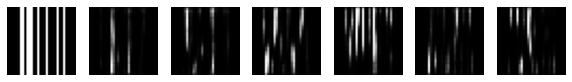

Epoch 371 gen_loss=2.190 disc_loss=0.228 real_acc=0.88 fake_acc=0.98
Epoch 372 gen_loss=1.843 disc_loss=0.240 real_acc=0.92 fake_acc=0.9
Epoch 373 gen_loss=1.905 disc_loss=0.216 real_acc=0.94 fake_acc=0.92
Epoch 374 gen_loss=1.914 disc_loss=0.230 real_acc=0.92 fake_acc=0.9
Epoch 375 gen_loss=2.073 disc_loss=0.185 real_acc=0.94 fake_acc=0.98
Epoch 376 gen_loss=2.395 disc_loss=0.211 real_acc=0.84 fake_acc=0.98
Epoch 377 gen_loss=2.478 disc_loss=0.222 real_acc=0.86 fake_acc=0.96
Epoch 378 gen_loss=2.527 disc_loss=0.213 real_acc=0.88 fake_acc=1.0
Epoch 379 gen_loss=2.323 disc_loss=0.199 real_acc=0.9 fake_acc=0.98
Epoch 380 gen_loss=2.065 disc_loss=0.193 real_acc=0.94 fake_acc=0.94


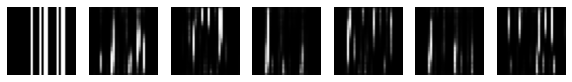

Epoch 381 gen_loss=2.159 disc_loss=0.221 real_acc=0.94 fake_acc=0.92
Epoch 382 gen_loss=2.144 disc_loss=0.220 real_acc=0.9 fake_acc=0.9
Epoch 383 gen_loss=1.977 disc_loss=0.204 real_acc=0.96 fake_acc=0.9
Epoch 384 gen_loss=2.154 disc_loss=0.210 real_acc=0.86 fake_acc=1.0
Epoch 385 gen_loss=2.428 disc_loss=0.165 real_acc=0.96 fake_acc=0.96
Epoch 386 gen_loss=2.402 disc_loss=0.156 real_acc=0.92 fake_acc=1.0
Epoch 387 gen_loss=2.266 disc_loss=0.225 real_acc=0.9 fake_acc=1.0
Epoch 388 gen_loss=2.264 disc_loss=0.198 real_acc=0.88 fake_acc=0.94
Epoch 389 gen_loss=2.256 disc_loss=0.187 real_acc=0.98 fake_acc=0.94
Epoch 390 gen_loss=2.296 disc_loss=0.218 real_acc=0.88 fake_acc=0.96


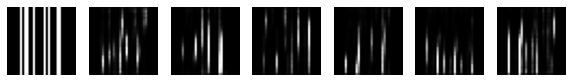

Epoch 391 gen_loss=2.083 disc_loss=0.160 real_acc=0.96 fake_acc=1.0
Epoch 392 gen_loss=2.066 disc_loss=0.203 real_acc=0.94 fake_acc=0.96
Epoch 393 gen_loss=2.081 disc_loss=0.170 real_acc=0.98 fake_acc=0.98
Epoch 394 gen_loss=2.238 disc_loss=0.205 real_acc=0.94 fake_acc=0.9
Epoch 395 gen_loss=2.351 disc_loss=0.203 real_acc=0.92 fake_acc=0.98
Epoch 396 gen_loss=2.426 disc_loss=0.161 real_acc=0.98 fake_acc=0.98
Epoch 397 gen_loss=2.487 disc_loss=0.170 real_acc=0.92 fake_acc=1.0
Epoch 398 gen_loss=2.504 disc_loss=0.202 real_acc=0.94 fake_acc=0.94
Epoch 399 gen_loss=2.258 disc_loss=0.198 real_acc=0.92 fake_acc=0.96
Epoch 400 gen_loss=2.232 disc_loss=0.169 real_acc=1.0 fake_acc=0.9


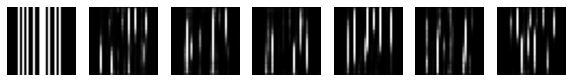

Epoch 401 gen_loss=2.193 disc_loss=0.200 real_acc=0.9 fake_acc=0.96
Epoch 402 gen_loss=2.238 disc_loss=0.193 real_acc=0.92 fake_acc=0.98
Epoch 403 gen_loss=1.970 disc_loss=0.197 real_acc=0.96 fake_acc=0.96
Epoch 404 gen_loss=2.267 disc_loss=0.147 real_acc=0.98 fake_acc=1.0
Epoch 405 gen_loss=2.229 disc_loss=0.171 real_acc=0.94 fake_acc=0.96
Epoch 406 gen_loss=2.011 disc_loss=0.185 real_acc=0.98 fake_acc=0.94
Epoch 407 gen_loss=2.306 disc_loss=0.177 real_acc=0.96 fake_acc=0.96
Epoch 408 gen_loss=2.463 disc_loss=0.217 real_acc=0.84 fake_acc=1.0
Epoch 409 gen_loss=2.653 disc_loss=0.205 real_acc=0.88 fake_acc=1.0
Epoch 410 gen_loss=2.252 disc_loss=0.172 real_acc=0.92 fake_acc=1.0


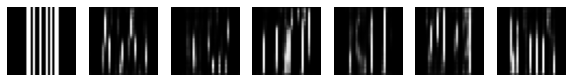

Epoch 411 gen_loss=2.295 disc_loss=0.190 real_acc=0.96 fake_acc=0.96
Epoch 412 gen_loss=1.834 disc_loss=0.240 real_acc=0.88 fake_acc=0.92
Epoch 413 gen_loss=1.788 disc_loss=0.212 real_acc=0.98 fake_acc=0.88
Epoch 414 gen_loss=2.295 disc_loss=0.199 real_acc=0.92 fake_acc=0.98
Epoch 415 gen_loss=2.509 disc_loss=0.178 real_acc=0.9 fake_acc=0.96
Epoch 416 gen_loss=2.598 disc_loss=0.168 real_acc=0.92 fake_acc=0.98
Epoch 417 gen_loss=2.573 disc_loss=0.153 real_acc=0.98 fake_acc=1.0
Epoch 418 gen_loss=2.335 disc_loss=0.209 real_acc=0.88 fake_acc=0.96
Epoch 419 gen_loss=2.369 disc_loss=0.254 real_acc=0.84 fake_acc=0.98
Epoch 420 gen_loss=1.985 disc_loss=0.246 real_acc=0.86 fake_acc=0.9


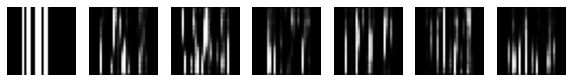

Epoch 421 gen_loss=1.960 disc_loss=0.185 real_acc=0.98 fake_acc=0.9
Epoch 422 gen_loss=2.014 disc_loss=0.182 real_acc=0.96 fake_acc=0.92
Epoch 423 gen_loss=2.220 disc_loss=0.238 real_acc=0.86 fake_acc=0.98
Epoch 424 gen_loss=2.543 disc_loss=0.228 real_acc=0.9 fake_acc=0.98
Epoch 425 gen_loss=2.412 disc_loss=0.179 real_acc=0.92 fake_acc=0.96
Epoch 426 gen_loss=2.337 disc_loss=0.210 real_acc=0.88 fake_acc=0.98
Epoch 427 gen_loss=2.315 disc_loss=0.189 real_acc=0.9 fake_acc=0.98
Epoch 428 gen_loss=1.918 disc_loss=0.211 real_acc=0.92 fake_acc=0.96
Epoch 429 gen_loss=2.084 disc_loss=0.202 real_acc=0.96 fake_acc=1.0
Epoch 430 gen_loss=2.190 disc_loss=0.173 real_acc=0.96 fake_acc=1.0


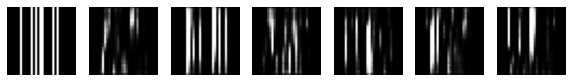

Epoch 431 gen_loss=2.278 disc_loss=0.219 real_acc=0.92 fake_acc=0.98
Epoch 432 gen_loss=2.762 disc_loss=0.175 real_acc=0.92 fake_acc=1.0
Epoch 433 gen_loss=2.082 disc_loss=0.207 real_acc=0.9 fake_acc=1.0
Epoch 434 gen_loss=2.220 disc_loss=0.197 real_acc=0.94 fake_acc=0.94
Epoch 435 gen_loss=2.437 disc_loss=0.230 real_acc=0.84 fake_acc=0.98
Epoch 436 gen_loss=2.205 disc_loss=0.187 real_acc=0.96 fake_acc=0.96
Epoch 437 gen_loss=1.984 disc_loss=0.194 real_acc=0.94 fake_acc=0.94
Epoch 438 gen_loss=2.152 disc_loss=0.202 real_acc=0.92 fake_acc=0.98
Epoch 439 gen_loss=2.312 disc_loss=0.200 real_acc=0.92 fake_acc=0.92
Epoch 440 gen_loss=2.334 disc_loss=0.216 real_acc=0.86 fake_acc=0.96


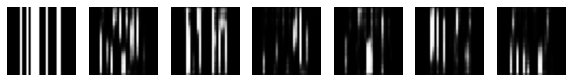

Epoch 441 gen_loss=2.368 disc_loss=0.235 real_acc=0.84 fake_acc=0.98
Epoch 442 gen_loss=2.424 disc_loss=0.214 real_acc=0.88 fake_acc=1.0
Epoch 443 gen_loss=2.036 disc_loss=0.214 real_acc=0.98 fake_acc=0.94
Epoch 444 gen_loss=2.080 disc_loss=0.225 real_acc=0.96 fake_acc=0.92
Epoch 445 gen_loss=2.040 disc_loss=0.181 real_acc=0.98 fake_acc=1.0
Epoch 446 gen_loss=2.426 disc_loss=0.185 real_acc=0.92 fake_acc=0.96
Epoch 447 gen_loss=2.460 disc_loss=0.185 real_acc=0.94 fake_acc=0.98
Epoch 448 gen_loss=2.508 disc_loss=0.195 real_acc=0.94 fake_acc=0.98
Epoch 449 gen_loss=2.551 disc_loss=0.138 real_acc=0.98 fake_acc=1.0
Epoch 450 gen_loss=2.337 disc_loss=0.186 real_acc=0.9 fake_acc=0.98


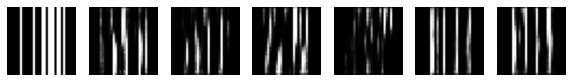

Epoch 451 gen_loss=2.260 disc_loss=0.201 real_acc=0.94 fake_acc=1.0
Epoch 452 gen_loss=2.118 disc_loss=0.228 real_acc=0.88 fake_acc=1.0
Epoch 453 gen_loss=1.948 disc_loss=0.210 real_acc=0.98 fake_acc=0.88
Epoch 454 gen_loss=2.131 disc_loss=0.196 real_acc=0.92 fake_acc=0.96
Epoch 455 gen_loss=2.378 disc_loss=0.216 real_acc=0.9 fake_acc=0.98
Epoch 456 gen_loss=2.251 disc_loss=0.156 real_acc=1.0 fake_acc=0.96
Epoch 457 gen_loss=2.407 disc_loss=0.163 real_acc=0.98 fake_acc=1.0
Epoch 458 gen_loss=2.535 disc_loss=0.221 real_acc=0.84 fake_acc=0.98
Epoch 459 gen_loss=2.407 disc_loss=0.190 real_acc=0.92 fake_acc=0.96
Epoch 460 gen_loss=2.483 disc_loss=0.203 real_acc=0.86 fake_acc=0.96


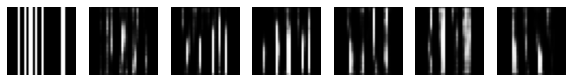

Epoch 461 gen_loss=2.155 disc_loss=0.226 real_acc=0.96 fake_acc=0.94
Epoch 462 gen_loss=2.024 disc_loss=0.214 real_acc=0.92 fake_acc=0.94
Epoch 463 gen_loss=1.871 disc_loss=0.218 real_acc=0.96 fake_acc=0.9
Epoch 464 gen_loss=2.380 disc_loss=0.199 real_acc=0.98 fake_acc=0.92
Epoch 465 gen_loss=2.650 disc_loss=0.172 real_acc=0.92 fake_acc=1.0
Epoch 466 gen_loss=2.794 disc_loss=0.197 real_acc=0.86 fake_acc=0.98
Epoch 467 gen_loss=2.908 disc_loss=0.188 real_acc=0.92 fake_acc=0.98
Epoch 468 gen_loss=2.521 disc_loss=0.167 real_acc=0.94 fake_acc=0.98
Epoch 469 gen_loss=2.519 disc_loss=0.219 real_acc=0.92 fake_acc=0.94
Epoch 470 gen_loss=2.216 disc_loss=0.186 real_acc=0.96 fake_acc=0.96


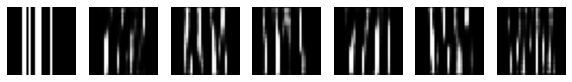

Epoch 471 gen_loss=1.816 disc_loss=0.222 real_acc=0.98 fake_acc=0.9
Epoch 472 gen_loss=2.151 disc_loss=0.181 real_acc=1.0 fake_acc=0.96
Epoch 473 gen_loss=2.392 disc_loss=0.190 real_acc=0.96 fake_acc=0.96
Epoch 474 gen_loss=2.927 disc_loss=0.176 real_acc=0.88 fake_acc=1.0
Epoch 475 gen_loss=2.872 disc_loss=0.196 real_acc=0.88 fake_acc=0.96
Epoch 476 gen_loss=2.606 disc_loss=0.205 real_acc=0.88 fake_acc=0.96
Epoch 477 gen_loss=2.118 disc_loss=0.213 real_acc=0.94 fake_acc=0.92
Epoch 478 gen_loss=1.954 disc_loss=0.200 real_acc=0.94 fake_acc=0.94
Epoch 479 gen_loss=1.941 disc_loss=0.186 real_acc=0.98 fake_acc=0.9
Epoch 480 gen_loss=2.028 disc_loss=0.159 real_acc=1.0 fake_acc=0.96


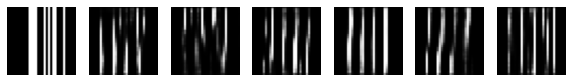

Epoch 481 gen_loss=2.712 disc_loss=0.185 real_acc=0.9 fake_acc=0.98
Epoch 482 gen_loss=2.744 disc_loss=0.202 real_acc=0.86 fake_acc=0.98
Epoch 483 gen_loss=3.154 disc_loss=0.151 real_acc=0.9 fake_acc=1.0
Epoch 484 gen_loss=2.761 disc_loss=0.203 real_acc=0.86 fake_acc=0.98
Epoch 485 gen_loss=2.200 disc_loss=0.188 real_acc=0.96 fake_acc=0.94
Epoch 486 gen_loss=2.019 disc_loss=0.174 real_acc=1.0 fake_acc=0.92
Epoch 487 gen_loss=2.206 disc_loss=0.196 real_acc=0.94 fake_acc=0.98
Epoch 488 gen_loss=2.107 disc_loss=0.159 real_acc=0.98 fake_acc=0.94
Epoch 489 gen_loss=2.517 disc_loss=0.155 real_acc=0.96 fake_acc=0.98
Epoch 490 gen_loss=2.632 disc_loss=0.182 real_acc=0.94 fake_acc=1.0


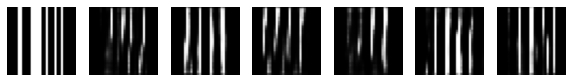

Epoch 491 gen_loss=2.758 disc_loss=0.163 real_acc=0.96 fake_acc=0.96
Epoch 492 gen_loss=2.589 disc_loss=0.201 real_acc=0.92 fake_acc=0.98
Epoch 493 gen_loss=2.449 disc_loss=0.147 real_acc=0.96 fake_acc=1.0
Epoch 494 gen_loss=2.181 disc_loss=0.180 real_acc=0.92 fake_acc=0.98
Epoch 495 gen_loss=2.293 disc_loss=0.182 real_acc=0.94 fake_acc=0.94
Epoch 496 gen_loss=2.265 disc_loss=0.199 real_acc=0.9 fake_acc=1.0
Epoch 497 gen_loss=2.142 disc_loss=0.161 real_acc=1.0 fake_acc=0.98
Epoch 498 gen_loss=2.399 disc_loss=0.179 real_acc=0.94 fake_acc=1.0
Epoch 499 gen_loss=2.667 disc_loss=0.191 real_acc=0.86 fake_acc=1.0
Epoch 500 gen_loss=2.405 disc_loss=0.140 real_acc=0.98 fake_acc=0.98


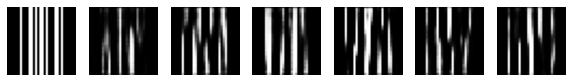

Epoch 501 gen_loss=2.721 disc_loss=0.174 real_acc=0.94 fake_acc=0.98
Epoch 502 gen_loss=2.327 disc_loss=0.189 real_acc=0.9 fake_acc=1.0
Epoch 503 gen_loss=2.509 disc_loss=0.142 real_acc=1.0 fake_acc=0.94
Epoch 504 gen_loss=2.135 disc_loss=0.194 real_acc=0.94 fake_acc=0.94
Epoch 505 gen_loss=2.454 disc_loss=0.219 real_acc=0.84 fake_acc=0.98
Epoch 506 gen_loss=2.393 disc_loss=0.185 real_acc=0.92 fake_acc=0.96
Epoch 507 gen_loss=2.364 disc_loss=0.155 real_acc=0.96 fake_acc=1.0
Epoch 508 gen_loss=2.430 disc_loss=0.184 real_acc=0.92 fake_acc=0.94
Epoch 509 gen_loss=2.343 disc_loss=0.188 real_acc=0.98 fake_acc=0.96
Epoch 510 gen_loss=2.310 disc_loss=0.169 real_acc=0.98 fake_acc=0.96


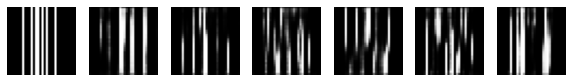

Epoch 511 gen_loss=2.537 disc_loss=0.179 real_acc=0.96 fake_acc=0.98
Epoch 512 gen_loss=2.659 disc_loss=0.171 real_acc=0.92 fake_acc=1.0
Epoch 513 gen_loss=2.879 disc_loss=0.129 real_acc=0.96 fake_acc=1.0
Epoch 514 gen_loss=2.324 disc_loss=0.173 real_acc=0.96 fake_acc=0.94
Epoch 515 gen_loss=2.233 disc_loss=0.172 real_acc=0.96 fake_acc=0.94
Epoch 516 gen_loss=2.729 disc_loss=0.174 real_acc=0.92 fake_acc=0.96
Epoch 517 gen_loss=2.529 disc_loss=0.206 real_acc=0.9 fake_acc=1.0
Epoch 518 gen_loss=2.394 disc_loss=0.166 real_acc=0.96 fake_acc=0.98
Epoch 519 gen_loss=2.446 disc_loss=0.172 real_acc=0.94 fake_acc=0.98
Epoch 520 gen_loss=2.399 disc_loss=0.140 real_acc=0.96 fake_acc=0.94


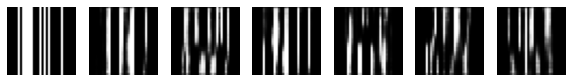

Epoch 521 gen_loss=2.368 disc_loss=0.141 real_acc=0.96 fake_acc=0.98
Epoch 522 gen_loss=2.636 disc_loss=0.173 real_acc=0.92 fake_acc=0.94
Epoch 523 gen_loss=2.876 disc_loss=0.178 real_acc=0.88 fake_acc=0.98
Epoch 524 gen_loss=2.601 disc_loss=0.196 real_acc=0.84 fake_acc=1.0
Epoch 525 gen_loss=2.315 disc_loss=0.221 real_acc=0.88 fake_acc=0.98
Epoch 526 gen_loss=2.109 disc_loss=0.206 real_acc=0.94 fake_acc=0.9
Epoch 527 gen_loss=2.103 disc_loss=0.148 real_acc=0.98 fake_acc=0.98
Epoch 528 gen_loss=2.557 disc_loss=0.175 real_acc=0.9 fake_acc=1.0
Epoch 529 gen_loss=2.406 disc_loss=0.164 real_acc=0.96 fake_acc=0.98
Epoch 530 gen_loss=2.708 disc_loss=0.158 real_acc=0.9 fake_acc=1.0


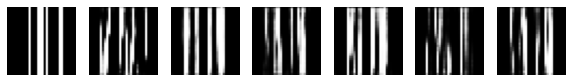

Epoch 531 gen_loss=2.667 disc_loss=0.171 real_acc=0.94 fake_acc=0.98
Epoch 532 gen_loss=2.554 disc_loss=0.158 real_acc=0.96 fake_acc=0.98
Epoch 533 gen_loss=2.243 disc_loss=0.199 real_acc=0.9 fake_acc=0.98
Epoch 534 gen_loss=2.081 disc_loss=0.166 real_acc=0.98 fake_acc=0.98
Epoch 535 gen_loss=2.174 disc_loss=0.168 real_acc=0.94 fake_acc=0.98
Epoch 536 gen_loss=2.549 disc_loss=0.185 real_acc=0.88 fake_acc=0.96
Epoch 537 gen_loss=2.766 disc_loss=0.128 real_acc=0.98 fake_acc=1.0
Epoch 538 gen_loss=2.823 disc_loss=0.154 real_acc=0.94 fake_acc=1.0
Epoch 539 gen_loss=2.597 disc_loss=0.226 real_acc=0.9 fake_acc=1.0
Epoch 540 gen_loss=2.480 disc_loss=0.163 real_acc=0.98 fake_acc=0.92


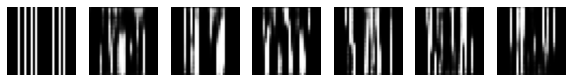

Epoch 541 gen_loss=2.362 disc_loss=0.179 real_acc=0.94 fake_acc=0.94
Epoch 542 gen_loss=2.605 disc_loss=0.171 real_acc=0.9 fake_acc=1.0
Epoch 543 gen_loss=2.466 disc_loss=0.161 real_acc=0.94 fake_acc=0.96
Epoch 544 gen_loss=2.684 disc_loss=0.150 real_acc=0.88 fake_acc=1.0
Epoch 545 gen_loss=2.548 disc_loss=0.172 real_acc=0.9 fake_acc=1.0
Epoch 546 gen_loss=2.487 disc_loss=0.143 real_acc=0.94 fake_acc=0.96
Epoch 547 gen_loss=2.669 disc_loss=0.123 real_acc=0.96 fake_acc=1.0
Epoch 548 gen_loss=2.675 disc_loss=0.169 real_acc=0.96 fake_acc=0.96
Epoch 549 gen_loss=2.602 disc_loss=0.168 real_acc=0.94 fake_acc=1.0
Epoch 550 gen_loss=2.428 disc_loss=0.144 real_acc=0.98 fake_acc=0.94


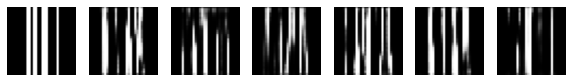

Epoch 551 gen_loss=2.726 disc_loss=0.185 real_acc=0.94 fake_acc=0.98
Epoch 552 gen_loss=2.543 disc_loss=0.151 real_acc=0.94 fake_acc=0.98
Epoch 553 gen_loss=2.708 disc_loss=0.179 real_acc=0.94 fake_acc=0.98
Epoch 554 gen_loss=2.291 disc_loss=0.148 real_acc=0.98 fake_acc=0.94
Epoch 555 gen_loss=2.190 disc_loss=0.212 real_acc=0.9 fake_acc=1.0
Epoch 556 gen_loss=2.532 disc_loss=0.138 real_acc=0.98 fake_acc=0.98
Epoch 557 gen_loss=2.908 disc_loss=0.145 real_acc=0.94 fake_acc=1.0
Epoch 558 gen_loss=2.740 disc_loss=0.185 real_acc=0.9 fake_acc=0.96
Epoch 559 gen_loss=2.904 disc_loss=0.171 real_acc=0.88 fake_acc=1.0
Epoch 560 gen_loss=2.428 disc_loss=0.145 real_acc=0.98 fake_acc=1.0


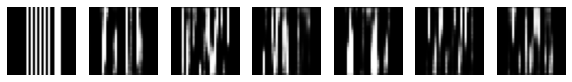

Epoch 561 gen_loss=2.291 disc_loss=0.177 real_acc=0.92 fake_acc=0.96
Epoch 562 gen_loss=2.154 disc_loss=0.195 real_acc=0.9 fake_acc=0.92
Epoch 563 gen_loss=2.321 disc_loss=0.166 real_acc=0.96 fake_acc=0.92
Epoch 564 gen_loss=2.930 disc_loss=0.154 real_acc=0.92 fake_acc=1.0
Epoch 565 gen_loss=2.685 disc_loss=0.216 real_acc=0.92 fake_acc=0.96
Epoch 566 gen_loss=2.189 disc_loss=0.243 real_acc=0.88 fake_acc=0.9
Epoch 567 gen_loss=2.529 disc_loss=0.154 real_acc=0.96 fake_acc=0.96
Epoch 568 gen_loss=2.391 disc_loss=0.255 real_acc=0.9 fake_acc=0.94
Epoch 569 gen_loss=2.521 disc_loss=0.211 real_acc=0.9 fake_acc=0.94
Epoch 570 gen_loss=2.309 disc_loss=0.187 real_acc=0.9 fake_acc=0.98


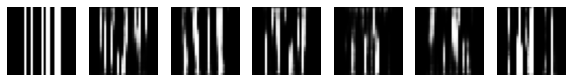

Epoch 571 gen_loss=2.522 disc_loss=0.188 real_acc=0.94 fake_acc=0.96
Epoch 572 gen_loss=2.559 disc_loss=0.156 real_acc=0.98 fake_acc=0.92
Epoch 573 gen_loss=2.578 disc_loss=0.180 real_acc=0.94 fake_acc=0.94
Epoch 574 gen_loss=2.591 disc_loss=0.169 real_acc=0.88 fake_acc=0.96
Epoch 575 gen_loss=2.850 disc_loss=0.157 real_acc=0.94 fake_acc=0.98
Epoch 576 gen_loss=2.580 disc_loss=0.213 real_acc=0.9 fake_acc=0.94
Epoch 577 gen_loss=2.634 disc_loss=0.175 real_acc=0.9 fake_acc=0.96
Epoch 578 gen_loss=2.547 disc_loss=0.161 real_acc=0.96 fake_acc=0.92
Epoch 579 gen_loss=2.742 disc_loss=0.214 real_acc=0.9 fake_acc=0.98
Epoch 580 gen_loss=2.653 disc_loss=0.161 real_acc=0.96 fake_acc=0.96


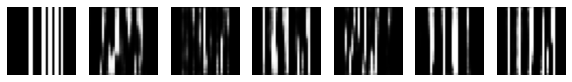

Epoch 581 gen_loss=2.767 disc_loss=0.170 real_acc=0.9 fake_acc=1.0
Epoch 582 gen_loss=2.398 disc_loss=0.175 real_acc=0.94 fake_acc=0.96
Epoch 583 gen_loss=2.311 disc_loss=0.174 real_acc=0.96 fake_acc=0.96
Epoch 584 gen_loss=2.371 disc_loss=0.206 real_acc=0.92 fake_acc=0.94
Epoch 585 gen_loss=2.317 disc_loss=0.179 real_acc=0.96 fake_acc=0.98
Epoch 586 gen_loss=2.691 disc_loss=0.251 real_acc=0.84 fake_acc=0.92
Epoch 587 gen_loss=2.399 disc_loss=0.258 real_acc=0.88 fake_acc=0.92
Epoch 588 gen_loss=2.331 disc_loss=0.161 real_acc=0.96 fake_acc=0.96
Epoch 589 gen_loss=2.482 disc_loss=0.200 real_acc=0.92 fake_acc=0.96
Epoch 590 gen_loss=2.164 disc_loss=0.243 real_acc=0.9 fake_acc=0.94


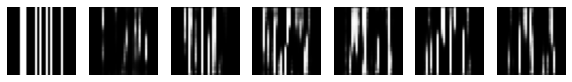

Epoch 591 gen_loss=2.748 disc_loss=0.276 real_acc=0.84 fake_acc=0.92
Epoch 592 gen_loss=2.596 disc_loss=0.226 real_acc=0.94 fake_acc=0.96
Epoch 593 gen_loss=2.375 disc_loss=0.255 real_acc=0.88 fake_acc=0.92
Epoch 594 gen_loss=2.075 disc_loss=0.276 real_acc=0.9 fake_acc=0.9
Epoch 595 gen_loss=2.231 disc_loss=0.247 real_acc=0.94 fake_acc=0.84
Epoch 596 gen_loss=2.224 disc_loss=0.253 real_acc=0.94 fake_acc=0.88
Epoch 597 gen_loss=2.498 disc_loss=0.278 real_acc=0.84 fake_acc=0.88
Epoch 598 gen_loss=2.296 disc_loss=0.247 real_acc=0.9 fake_acc=0.9
Epoch 599 gen_loss=2.513 disc_loss=0.224 real_acc=0.92 fake_acc=0.94
Epoch 600 gen_loss=2.901 disc_loss=0.221 real_acc=0.9 fake_acc=0.94


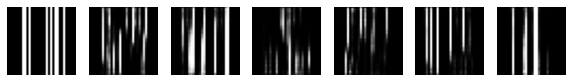

Epoch 601 gen_loss=2.902 disc_loss=0.298 real_acc=0.78 fake_acc=0.96
Epoch 602 gen_loss=2.376 disc_loss=0.194 real_acc=0.94 fake_acc=0.96
Epoch 603 gen_loss=2.003 disc_loss=0.323 real_acc=0.9 fake_acc=0.82
Epoch 604 gen_loss=1.824 disc_loss=0.226 real_acc=0.96 fake_acc=0.86
Epoch 605 gen_loss=2.003 disc_loss=0.280 real_acc=0.88 fake_acc=0.86
Epoch 606 gen_loss=2.457 disc_loss=0.295 real_acc=0.84 fake_acc=0.94
Epoch 607 gen_loss=2.799 disc_loss=0.258 real_acc=0.84 fake_acc=0.96
Epoch 608 gen_loss=2.473 disc_loss=0.251 real_acc=0.88 fake_acc=0.96
Epoch 609 gen_loss=2.518 disc_loss=0.230 real_acc=0.92 fake_acc=0.96
Epoch 610 gen_loss=1.600 disc_loss=0.263 real_acc=0.98 fake_acc=0.74


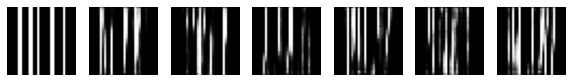

Epoch 611 gen_loss=2.139 disc_loss=0.236 real_acc=0.96 fake_acc=0.9
Epoch 612 gen_loss=2.593 disc_loss=0.218 real_acc=0.84 fake_acc=0.98
Epoch 613 gen_loss=2.392 disc_loss=0.260 real_acc=0.8 fake_acc=1.0
Epoch 614 gen_loss=2.451 disc_loss=0.233 real_acc=0.94 fake_acc=0.92
Epoch 615 gen_loss=2.504 disc_loss=0.228 real_acc=0.9 fake_acc=0.94
Epoch 616 gen_loss=2.538 disc_loss=0.216 real_acc=0.94 fake_acc=0.96
Epoch 617 gen_loss=2.212 disc_loss=0.207 real_acc=0.96 fake_acc=0.86
Epoch 618 gen_loss=2.262 disc_loss=0.208 real_acc=0.96 fake_acc=0.92
Epoch 619 gen_loss=2.649 disc_loss=0.248 real_acc=0.84 fake_acc=0.94
Epoch 620 gen_loss=2.589 disc_loss=0.265 real_acc=0.84 fake_acc=0.84


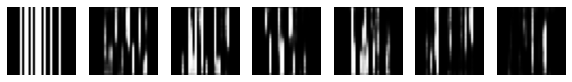

Epoch 621 gen_loss=2.378 disc_loss=0.206 real_acc=0.9 fake_acc=0.92
Epoch 622 gen_loss=2.670 disc_loss=0.220 real_acc=0.9 fake_acc=0.88
Epoch 623 gen_loss=2.384 disc_loss=0.203 real_acc=0.96 fake_acc=0.98
Epoch 624 gen_loss=2.502 disc_loss=0.249 real_acc=0.96 fake_acc=0.88
Epoch 625 gen_loss=2.080 disc_loss=0.237 real_acc=0.94 fake_acc=0.9
Epoch 626 gen_loss=2.337 disc_loss=0.275 real_acc=0.82 fake_acc=0.9
Epoch 627 gen_loss=2.551 disc_loss=0.238 real_acc=0.9 fake_acc=0.9
Epoch 628 gen_loss=2.518 disc_loss=0.276 real_acc=0.9 fake_acc=0.9
Epoch 629 gen_loss=2.696 disc_loss=0.185 real_acc=0.96 fake_acc=0.92
Epoch 630 gen_loss=2.309 disc_loss=0.258 real_acc=0.88 fake_acc=0.94


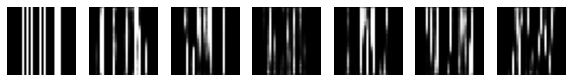

Epoch 631 gen_loss=2.180 disc_loss=0.280 real_acc=0.96 fake_acc=0.8
Epoch 632 gen_loss=2.309 disc_loss=0.241 real_acc=0.96 fake_acc=0.9
Epoch 633 gen_loss=2.655 disc_loss=0.295 real_acc=0.84 fake_acc=0.9
Epoch 634 gen_loss=2.624 disc_loss=0.225 real_acc=0.92 fake_acc=0.94
Epoch 635 gen_loss=2.500 disc_loss=0.209 real_acc=0.88 fake_acc=1.0
Epoch 636 gen_loss=2.211 disc_loss=0.282 real_acc=0.96 fake_acc=0.74
Epoch 637 gen_loss=2.518 disc_loss=0.237 real_acc=0.86 fake_acc=0.94
Epoch 638 gen_loss=2.458 disc_loss=0.190 real_acc=0.98 fake_acc=0.88
Epoch 639 gen_loss=2.275 disc_loss=0.241 real_acc=0.88 fake_acc=0.92
Epoch 640 gen_loss=2.889 disc_loss=0.195 real_acc=0.92 fake_acc=0.98


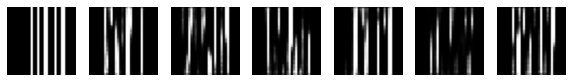

Epoch 641 gen_loss=2.476 disc_loss=0.225 real_acc=0.9 fake_acc=0.94
Epoch 642 gen_loss=2.500 disc_loss=0.223 real_acc=0.9 fake_acc=0.9
Epoch 643 gen_loss=2.445 disc_loss=0.185 real_acc=0.96 fake_acc=0.92
Epoch 644 gen_loss=2.403 disc_loss=0.187 real_acc=0.96 fake_acc=0.92
Epoch 645 gen_loss=2.347 disc_loss=0.237 real_acc=0.96 fake_acc=0.9
Epoch 646 gen_loss=2.334 disc_loss=0.186 real_acc=0.96 fake_acc=0.88
Epoch 647 gen_loss=2.905 disc_loss=0.176 real_acc=0.92 fake_acc=0.98
Epoch 648 gen_loss=2.778 disc_loss=0.220 real_acc=0.86 fake_acc=1.0
Epoch 649 gen_loss=2.969 disc_loss=0.209 real_acc=0.88 fake_acc=0.92
Epoch 650 gen_loss=2.774 disc_loss=0.164 real_acc=0.94 fake_acc=0.98


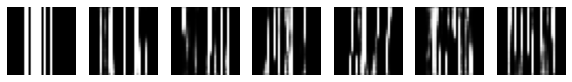

Epoch 651 gen_loss=2.313 disc_loss=0.220 real_acc=1.0 fake_acc=0.86
Epoch 652 gen_loss=2.397 disc_loss=0.189 real_acc=0.94 fake_acc=0.94
Epoch 653 gen_loss=2.608 disc_loss=0.184 real_acc=0.94 fake_acc=0.92
Epoch 654 gen_loss=2.843 disc_loss=0.149 real_acc=0.98 fake_acc=0.9
Epoch 655 gen_loss=2.811 disc_loss=0.140 real_acc=0.96 fake_acc=0.98
Epoch 656 gen_loss=3.033 disc_loss=0.185 real_acc=0.88 fake_acc=0.98
Epoch 657 gen_loss=2.665 disc_loss=0.230 real_acc=0.86 fake_acc=0.94
Epoch 658 gen_loss=2.581 disc_loss=0.208 real_acc=0.92 fake_acc=0.98
Epoch 659 gen_loss=2.389 disc_loss=0.164 real_acc=0.96 fake_acc=0.96
Epoch 660 gen_loss=2.113 disc_loss=0.188 real_acc=0.94 fake_acc=0.96


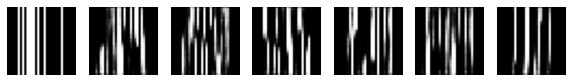

Epoch 661 gen_loss=2.238 disc_loss=0.180 real_acc=0.98 fake_acc=0.9
Epoch 662 gen_loss=2.829 disc_loss=0.217 real_acc=0.88 fake_acc=0.92
Epoch 663 gen_loss=2.645 disc_loss=0.191 real_acc=0.9 fake_acc=0.96
Epoch 664 gen_loss=3.190 disc_loss=0.182 real_acc=0.88 fake_acc=1.0
Epoch 665 gen_loss=3.132 disc_loss=0.172 real_acc=0.9 fake_acc=0.98
Epoch 666 gen_loss=3.139 disc_loss=0.140 real_acc=0.96 fake_acc=1.0
Epoch 667 gen_loss=2.805 disc_loss=0.181 real_acc=0.92 fake_acc=1.0
Epoch 668 gen_loss=2.184 disc_loss=0.214 real_acc=0.96 fake_acc=0.82
Epoch 669 gen_loss=2.270 disc_loss=0.173 real_acc=0.98 fake_acc=0.92
Epoch 670 gen_loss=2.455 disc_loss=0.158 real_acc=0.96 fake_acc=1.0


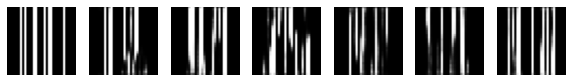

Epoch 671 gen_loss=2.782 disc_loss=0.237 real_acc=0.88 fake_acc=0.94
Epoch 672 gen_loss=2.967 disc_loss=0.160 real_acc=0.94 fake_acc=0.98
Epoch 673 gen_loss=2.410 disc_loss=0.198 real_acc=0.9 fake_acc=0.94
Epoch 674 gen_loss=2.529 disc_loss=0.193 real_acc=0.88 fake_acc=0.96
Epoch 675 gen_loss=2.856 disc_loss=0.140 real_acc=0.98 fake_acc=0.94
Epoch 676 gen_loss=2.728 disc_loss=0.191 real_acc=0.92 fake_acc=0.98
Epoch 677 gen_loss=2.907 disc_loss=0.144 real_acc=0.96 fake_acc=0.98
Epoch 678 gen_loss=2.759 disc_loss=0.143 real_acc=0.94 fake_acc=0.94
Epoch 679 gen_loss=2.792 disc_loss=0.177 real_acc=0.96 fake_acc=0.96
Epoch 680 gen_loss=2.863 disc_loss=0.120 real_acc=0.98 fake_acc=0.98


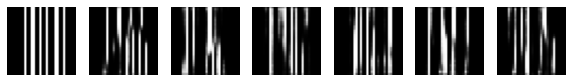

Epoch 681 gen_loss=2.775 disc_loss=0.162 real_acc=0.98 fake_acc=0.94
Epoch 682 gen_loss=2.665 disc_loss=0.149 real_acc=1.0 fake_acc=0.9
Epoch 683 gen_loss=2.943 disc_loss=0.154 real_acc=0.96 fake_acc=0.98
Epoch 684 gen_loss=2.775 disc_loss=0.157 real_acc=0.94 fake_acc=0.94
Epoch 685 gen_loss=2.912 disc_loss=0.174 real_acc=0.92 fake_acc=1.0
Epoch 686 gen_loss=2.799 disc_loss=0.172 real_acc=0.94 fake_acc=1.0
Epoch 687 gen_loss=2.574 disc_loss=0.151 real_acc=0.94 fake_acc=1.0
Epoch 688 gen_loss=2.141 disc_loss=0.199 real_acc=0.92 fake_acc=0.94
Epoch 689 gen_loss=2.451 disc_loss=0.145 real_acc=0.96 fake_acc=0.98
Epoch 690 gen_loss=2.414 disc_loss=0.168 real_acc=0.96 fake_acc=0.98


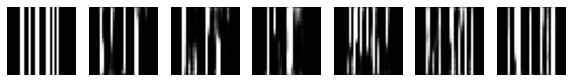

Epoch 691 gen_loss=2.829 disc_loss=0.175 real_acc=0.92 fake_acc=0.96
Epoch 692 gen_loss=2.733 disc_loss=0.183 real_acc=0.94 fake_acc=0.98
Epoch 693 gen_loss=2.515 disc_loss=0.172 real_acc=0.94 fake_acc=0.96
Epoch 694 gen_loss=2.839 disc_loss=0.214 real_acc=0.88 fake_acc=0.96
Epoch 695 gen_loss=2.405 disc_loss=0.160 real_acc=0.98 fake_acc=0.94
Epoch 696 gen_loss=2.586 disc_loss=0.231 real_acc=0.9 fake_acc=0.94
Epoch 697 gen_loss=2.839 disc_loss=0.172 real_acc=0.94 fake_acc=0.92
Epoch 698 gen_loss=2.637 disc_loss=0.170 real_acc=0.94 fake_acc=0.98
Epoch 699 gen_loss=3.041 disc_loss=0.121 real_acc=0.98 fake_acc=0.98
Epoch 700 gen_loss=2.726 disc_loss=0.180 real_acc=0.9 fake_acc=0.98


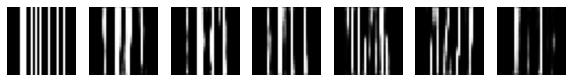

Epoch 701 gen_loss=2.792 disc_loss=0.177 real_acc=0.94 fake_acc=0.96
Epoch 702 gen_loss=2.969 disc_loss=0.155 real_acc=0.96 fake_acc=0.98
Epoch 703 gen_loss=2.415 disc_loss=0.204 real_acc=0.96 fake_acc=0.92
Epoch 704 gen_loss=2.634 disc_loss=0.203 real_acc=0.92 fake_acc=0.96
Epoch 705 gen_loss=2.459 disc_loss=0.159 real_acc=0.94 fake_acc=0.94
Epoch 706 gen_loss=2.957 disc_loss=0.176 real_acc=0.96 fake_acc=0.94
Epoch 707 gen_loss=3.153 disc_loss=0.173 real_acc=0.92 fake_acc=0.98
Epoch 708 gen_loss=2.654 disc_loss=0.187 real_acc=0.94 fake_acc=0.94
Epoch 709 gen_loss=2.530 disc_loss=0.183 real_acc=0.96 fake_acc=0.92
Epoch 710 gen_loss=2.516 disc_loss=0.179 real_acc=0.92 fake_acc=1.0


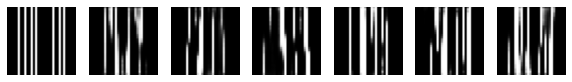

Epoch 711 gen_loss=2.728 disc_loss=0.158 real_acc=0.94 fake_acc=0.98
Epoch 712 gen_loss=2.414 disc_loss=0.190 real_acc=0.92 fake_acc=0.94
Epoch 713 gen_loss=2.512 disc_loss=0.200 real_acc=0.98 fake_acc=0.98
Epoch 714 gen_loss=3.059 disc_loss=0.137 real_acc=0.92 fake_acc=0.98
Epoch 715 gen_loss=2.959 disc_loss=0.159 real_acc=0.94 fake_acc=0.96
Epoch 716 gen_loss=3.175 disc_loss=0.145 real_acc=0.92 fake_acc=1.0
Epoch 717 gen_loss=2.611 disc_loss=0.123 real_acc=0.98 fake_acc=0.98
Epoch 718 gen_loss=2.262 disc_loss=0.170 real_acc=0.92 fake_acc=0.92
Epoch 719 gen_loss=2.456 disc_loss=0.171 real_acc=0.96 fake_acc=0.92
Epoch 720 gen_loss=3.051 disc_loss=0.140 real_acc=0.92 fake_acc=1.0


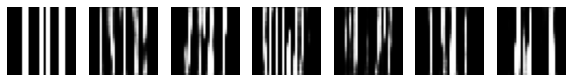

Epoch 721 gen_loss=2.774 disc_loss=0.186 real_acc=0.94 fake_acc=0.96
Epoch 722 gen_loss=3.283 disc_loss=0.158 real_acc=0.94 fake_acc=0.98
Epoch 723 gen_loss=2.928 disc_loss=0.191 real_acc=0.9 fake_acc=0.96
Epoch 724 gen_loss=2.530 disc_loss=0.202 real_acc=0.92 fake_acc=0.92
Epoch 725 gen_loss=2.770 disc_loss=0.200 real_acc=0.9 fake_acc=0.94
Epoch 726 gen_loss=2.434 disc_loss=0.164 real_acc=0.96 fake_acc=0.92
Epoch 727 gen_loss=2.587 disc_loss=0.160 real_acc=0.96 fake_acc=0.96
Epoch 728 gen_loss=2.592 disc_loss=0.137 real_acc=0.96 fake_acc=0.98
Epoch 729 gen_loss=3.038 disc_loss=0.133 real_acc=0.94 fake_acc=1.0
Epoch 730 gen_loss=3.450 disc_loss=0.212 real_acc=0.84 fake_acc=1.0


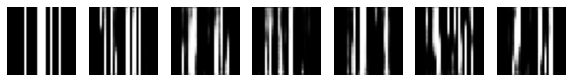

Epoch 731 gen_loss=3.130 disc_loss=0.184 real_acc=0.88 fake_acc=0.98
Epoch 732 gen_loss=2.543 disc_loss=0.186 real_acc=0.98 fake_acc=0.88
Epoch 733 gen_loss=2.251 disc_loss=0.207 real_acc=1.0 fake_acc=0.94
Epoch 734 gen_loss=2.832 disc_loss=0.138 real_acc=0.96 fake_acc=0.96
Epoch 735 gen_loss=2.402 disc_loss=0.158 real_acc=0.96 fake_acc=0.96
Epoch 736 gen_loss=2.897 disc_loss=0.184 real_acc=0.88 fake_acc=1.0
Epoch 737 gen_loss=2.750 disc_loss=0.150 real_acc=0.92 fake_acc=0.98
Epoch 738 gen_loss=2.604 disc_loss=0.201 real_acc=0.92 fake_acc=0.94
Epoch 739 gen_loss=2.607 disc_loss=0.162 real_acc=0.98 fake_acc=0.96
Epoch 740 gen_loss=2.654 disc_loss=0.145 real_acc=0.96 fake_acc=0.98


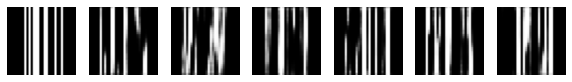

Epoch 741 gen_loss=2.507 disc_loss=0.179 real_acc=0.94 fake_acc=0.96
Epoch 742 gen_loss=3.012 disc_loss=0.148 real_acc=0.96 fake_acc=0.96
Epoch 743 gen_loss=3.117 disc_loss=0.141 real_acc=0.96 fake_acc=0.98
Epoch 744 gen_loss=3.045 disc_loss=0.214 real_acc=0.84 fake_acc=0.96
Epoch 745 gen_loss=2.947 disc_loss=0.179 real_acc=0.92 fake_acc=0.98
Epoch 746 gen_loss=2.391 disc_loss=0.167 real_acc=0.98 fake_acc=0.94
Epoch 747 gen_loss=2.336 disc_loss=0.155 real_acc=0.98 fake_acc=0.96
Epoch 748 gen_loss=2.148 disc_loss=0.197 real_acc=0.96 fake_acc=0.92
Epoch 749 gen_loss=2.592 disc_loss=0.195 real_acc=0.94 fake_acc=0.92
Epoch 750 gen_loss=3.258 disc_loss=0.208 real_acc=0.88 fake_acc=0.96


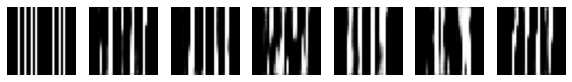

Epoch 751 gen_loss=3.161 disc_loss=0.244 real_acc=0.82 fake_acc=0.98
Epoch 752 gen_loss=2.824 disc_loss=0.139 real_acc=0.98 fake_acc=0.98
Epoch 753 gen_loss=2.614 disc_loss=0.140 real_acc=1.0 fake_acc=0.92
Epoch 754 gen_loss=2.318 disc_loss=0.164 real_acc=0.98 fake_acc=0.88
Epoch 755 gen_loss=2.811 disc_loss=0.133 real_acc=0.98 fake_acc=0.98
Epoch 756 gen_loss=3.047 disc_loss=0.132 real_acc=0.94 fake_acc=0.98
Epoch 757 gen_loss=3.265 disc_loss=0.137 real_acc=0.96 fake_acc=1.0
Epoch 758 gen_loss=2.874 disc_loss=0.200 real_acc=0.88 fake_acc=1.0
Epoch 759 gen_loss=2.711 disc_loss=0.223 real_acc=0.86 fake_acc=0.92
Epoch 760 gen_loss=2.100 disc_loss=0.181 real_acc=0.94 fake_acc=0.94


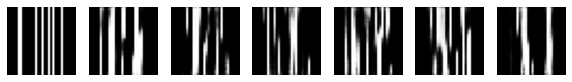

Epoch 761 gen_loss=2.232 disc_loss=0.158 real_acc=1.0 fake_acc=0.94
Epoch 762 gen_loss=2.657 disc_loss=0.142 real_acc=0.98 fake_acc=0.98
Epoch 763 gen_loss=2.657 disc_loss=0.216 real_acc=0.9 fake_acc=0.96
Epoch 764 gen_loss=3.106 disc_loss=0.180 real_acc=0.92 fake_acc=0.98
Epoch 765 gen_loss=3.597 disc_loss=0.223 real_acc=0.82 fake_acc=0.98
Epoch 766 gen_loss=2.956 disc_loss=0.138 real_acc=0.96 fake_acc=0.96
Epoch 767 gen_loss=2.468 disc_loss=0.189 real_acc=0.94 fake_acc=0.92
Epoch 768 gen_loss=2.036 disc_loss=0.249 real_acc=0.96 fake_acc=0.84
Epoch 769 gen_loss=2.407 disc_loss=0.211 real_acc=0.98 fake_acc=0.86
Epoch 770 gen_loss=3.087 disc_loss=0.200 real_acc=0.9 fake_acc=0.98


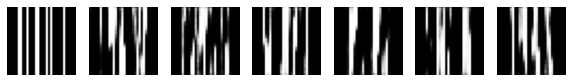

Epoch 771 gen_loss=3.227 disc_loss=0.135 real_acc=0.96 fake_acc=1.0
Epoch 772 gen_loss=2.918 disc_loss=0.226 real_acc=0.84 fake_acc=0.96
Epoch 773 gen_loss=2.678 disc_loss=0.171 real_acc=0.98 fake_acc=0.9
Epoch 774 gen_loss=2.758 disc_loss=0.179 real_acc=0.96 fake_acc=0.94
Epoch 775 gen_loss=2.608 disc_loss=0.145 real_acc=0.98 fake_acc=0.92
Epoch 776 gen_loss=2.993 disc_loss=0.153 real_acc=0.96 fake_acc=0.94
Epoch 777 gen_loss=2.787 disc_loss=0.184 real_acc=0.94 fake_acc=0.94
Epoch 778 gen_loss=3.742 disc_loss=0.163 real_acc=0.88 fake_acc=1.0
Epoch 779 gen_loss=3.131 disc_loss=0.207 real_acc=0.86 fake_acc=0.96
Epoch 780 gen_loss=2.487 disc_loss=0.179 real_acc=0.94 fake_acc=0.96


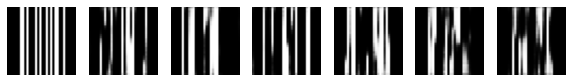

Epoch 781 gen_loss=2.134 disc_loss=0.198 real_acc=0.98 fake_acc=0.84
Epoch 782 gen_loss=2.303 disc_loss=0.191 real_acc=0.94 fake_acc=0.9
Epoch 783 gen_loss=2.827 disc_loss=0.144 real_acc=0.96 fake_acc=0.94
Epoch 784 gen_loss=3.088 disc_loss=0.223 real_acc=0.88 fake_acc=0.98
Epoch 785 gen_loss=3.401 disc_loss=0.211 real_acc=0.84 fake_acc=0.98
Epoch 786 gen_loss=2.697 disc_loss=0.188 real_acc=0.92 fake_acc=0.92
Epoch 787 gen_loss=2.365 disc_loss=0.264 real_acc=0.9 fake_acc=0.88
Epoch 788 gen_loss=2.320 disc_loss=0.164 real_acc=0.98 fake_acc=0.88
Epoch 789 gen_loss=2.594 disc_loss=0.124 real_acc=0.98 fake_acc=1.0
Epoch 790 gen_loss=2.952 disc_loss=0.188 real_acc=0.9 fake_acc=0.98


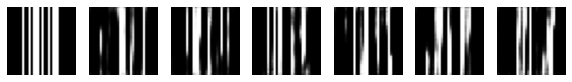

Epoch 791 gen_loss=2.848 disc_loss=0.216 real_acc=0.88 fake_acc=0.96
Epoch 792 gen_loss=2.818 disc_loss=0.143 real_acc=0.92 fake_acc=1.0
Epoch 793 gen_loss=2.816 disc_loss=0.180 real_acc=0.92 fake_acc=0.96
Epoch 794 gen_loss=2.488 disc_loss=0.161 real_acc=0.94 fake_acc=0.94
Epoch 795 gen_loss=2.582 disc_loss=0.173 real_acc=0.96 fake_acc=0.96
Epoch 796 gen_loss=2.879 disc_loss=0.171 real_acc=0.94 fake_acc=0.96
Epoch 797 gen_loss=3.037 disc_loss=0.183 real_acc=0.92 fake_acc=0.96
Epoch 798 gen_loss=2.880 disc_loss=0.131 real_acc=0.98 fake_acc=0.98
Epoch 799 gen_loss=2.807 disc_loss=0.201 real_acc=0.94 fake_acc=0.94
Epoch 800 gen_loss=3.104 disc_loss=0.134 real_acc=0.96 fake_acc=0.98


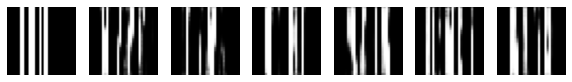

Epoch 801 gen_loss=2.769 disc_loss=0.186 real_acc=0.92 fake_acc=0.94
Epoch 802 gen_loss=2.755 disc_loss=0.257 real_acc=0.88 fake_acc=0.94
Epoch 803 gen_loss=2.814 disc_loss=0.207 real_acc=0.88 fake_acc=0.92
Epoch 804 gen_loss=2.400 disc_loss=0.189 real_acc=0.94 fake_acc=0.9
Epoch 805 gen_loss=2.438 disc_loss=0.255 real_acc=0.9 fake_acc=0.9
Epoch 806 gen_loss=2.576 disc_loss=0.192 real_acc=0.9 fake_acc=0.96
Epoch 807 gen_loss=2.532 disc_loss=0.198 real_acc=0.92 fake_acc=0.92
Epoch 808 gen_loss=2.700 disc_loss=0.261 real_acc=0.84 fake_acc=0.94
Epoch 809 gen_loss=2.914 disc_loss=0.179 real_acc=0.88 fake_acc=0.98
Epoch 810 gen_loss=2.911 disc_loss=0.207 real_acc=0.92 fake_acc=0.94


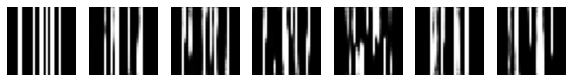

Epoch 811 gen_loss=2.690 disc_loss=0.188 real_acc=0.98 fake_acc=0.9
Epoch 812 gen_loss=2.906 disc_loss=0.170 real_acc=0.88 fake_acc=0.96
Epoch 813 gen_loss=2.942 disc_loss=0.278 real_acc=0.84 fake_acc=0.94
Epoch 814 gen_loss=2.521 disc_loss=0.213 real_acc=0.92 fake_acc=0.96
Epoch 815 gen_loss=2.107 disc_loss=0.243 real_acc=0.9 fake_acc=0.86
Epoch 816 gen_loss=2.754 disc_loss=0.151 real_acc=0.96 fake_acc=0.96
Epoch 817 gen_loss=2.702 disc_loss=0.159 real_acc=0.94 fake_acc=0.96
Epoch 818 gen_loss=2.575 disc_loss=0.251 real_acc=0.86 fake_acc=0.94
Epoch 819 gen_loss=3.192 disc_loss=0.183 real_acc=0.9 fake_acc=1.0
Epoch 820 gen_loss=2.782 disc_loss=0.236 real_acc=0.9 fake_acc=0.94


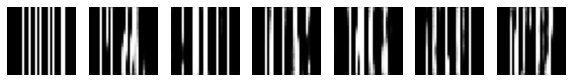

Epoch 821 gen_loss=2.839 disc_loss=0.146 real_acc=0.92 fake_acc=1.0
Epoch 822 gen_loss=2.390 disc_loss=0.201 real_acc=0.96 fake_acc=0.86
Epoch 823 gen_loss=2.543 disc_loss=0.154 real_acc=0.94 fake_acc=0.94
Epoch 824 gen_loss=2.923 disc_loss=0.171 real_acc=0.94 fake_acc=0.94
Epoch 825 gen_loss=3.276 disc_loss=0.153 real_acc=0.88 fake_acc=1.0
Epoch 826 gen_loss=3.411 disc_loss=0.208 real_acc=0.8 fake_acc=0.98
Epoch 827 gen_loss=2.678 disc_loss=0.239 real_acc=0.88 fake_acc=0.96
Epoch 828 gen_loss=2.322 disc_loss=0.236 real_acc=0.9 fake_acc=0.92
Epoch 829 gen_loss=2.076 disc_loss=0.256 real_acc=0.94 fake_acc=0.8
Epoch 830 gen_loss=1.854 disc_loss=0.322 real_acc=0.92 fake_acc=0.7


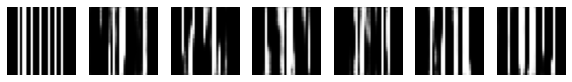

Epoch 831 gen_loss=2.323 disc_loss=0.263 real_acc=0.88 fake_acc=0.86
Epoch 832 gen_loss=3.281 disc_loss=0.169 real_acc=0.9 fake_acc=0.98
Epoch 833 gen_loss=3.784 disc_loss=0.197 real_acc=0.9 fake_acc=1.0
Epoch 834 gen_loss=3.307 disc_loss=0.194 real_acc=0.86 fake_acc=0.96
Epoch 835 gen_loss=2.739 disc_loss=0.193 real_acc=0.94 fake_acc=0.96
Epoch 836 gen_loss=2.323 disc_loss=0.214 real_acc=0.94 fake_acc=0.9
Epoch 837 gen_loss=2.168 disc_loss=0.209 real_acc=0.96 fake_acc=0.86
Epoch 838 gen_loss=2.232 disc_loss=0.231 real_acc=0.92 fake_acc=0.88
Epoch 839 gen_loss=2.932 disc_loss=0.160 real_acc=0.94 fake_acc=0.98
Epoch 840 gen_loss=3.305 disc_loss=0.253 real_acc=0.8 fake_acc=0.96


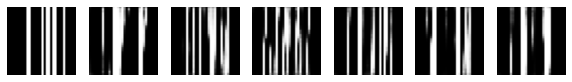

Epoch 841 gen_loss=3.596 disc_loss=0.189 real_acc=0.88 fake_acc=1.0
Epoch 842 gen_loss=3.037 disc_loss=0.215 real_acc=0.86 fake_acc=0.98
Epoch 843 gen_loss=2.119 disc_loss=0.216 real_acc=0.96 fake_acc=0.92
Epoch 844 gen_loss=2.274 disc_loss=0.188 real_acc=0.94 fake_acc=0.96
Epoch 845 gen_loss=2.155 disc_loss=0.178 real_acc=0.96 fake_acc=0.86
Epoch 846 gen_loss=2.536 disc_loss=0.146 real_acc=1.0 fake_acc=0.96
Epoch 847 gen_loss=3.151 disc_loss=0.149 real_acc=0.94 fake_acc=0.98
Epoch 848 gen_loss=3.337 disc_loss=0.177 real_acc=0.86 fake_acc=1.0
Epoch 849 gen_loss=3.034 disc_loss=0.189 real_acc=0.9 fake_acc=0.94
Epoch 850 gen_loss=3.112 disc_loss=0.180 real_acc=0.94 fake_acc=0.94


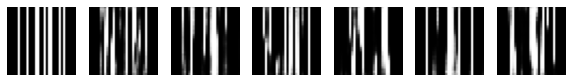

Epoch 851 gen_loss=3.039 disc_loss=0.169 real_acc=0.94 fake_acc=0.96
Epoch 852 gen_loss=2.630 disc_loss=0.201 real_acc=0.96 fake_acc=0.92
Epoch 853 gen_loss=2.592 disc_loss=0.214 real_acc=0.96 fake_acc=0.9
Epoch 854 gen_loss=2.639 disc_loss=0.200 real_acc=0.9 fake_acc=0.96
Epoch 855 gen_loss=2.814 disc_loss=0.157 real_acc=0.96 fake_acc=0.9
Epoch 856 gen_loss=3.008 disc_loss=0.156 real_acc=0.94 fake_acc=0.98
Epoch 857 gen_loss=3.070 disc_loss=0.179 real_acc=0.92 fake_acc=0.98
Epoch 858 gen_loss=2.613 disc_loss=0.190 real_acc=0.92 fake_acc=0.94
Epoch 859 gen_loss=2.757 disc_loss=0.155 real_acc=0.94 fake_acc=0.98
Epoch 860 gen_loss=2.883 disc_loss=0.127 real_acc=0.96 fake_acc=0.98


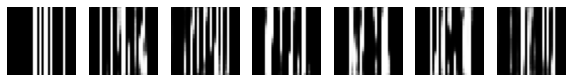

Epoch 861 gen_loss=2.837 disc_loss=0.231 real_acc=0.86 fake_acc=0.96
Epoch 862 gen_loss=2.394 disc_loss=0.247 real_acc=0.88 fake_acc=0.82
Epoch 863 gen_loss=2.567 disc_loss=0.201 real_acc=0.94 fake_acc=0.94
Epoch 864 gen_loss=2.678 disc_loss=0.228 real_acc=0.88 fake_acc=0.92
Epoch 865 gen_loss=2.716 disc_loss=0.217 real_acc=0.88 fake_acc=0.92
Epoch 866 gen_loss=2.486 disc_loss=0.220 real_acc=0.94 fake_acc=0.94
Epoch 867 gen_loss=2.792 disc_loss=0.223 real_acc=0.86 fake_acc=0.98
Epoch 868 gen_loss=2.878 disc_loss=0.154 real_acc=0.92 fake_acc=1.0
Epoch 869 gen_loss=2.664 disc_loss=0.174 real_acc=0.96 fake_acc=0.96
Epoch 870 gen_loss=2.855 disc_loss=0.173 real_acc=0.94 fake_acc=0.96


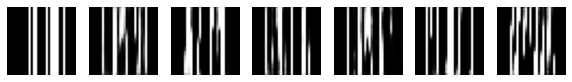

Epoch 871 gen_loss=2.380 disc_loss=0.227 real_acc=0.94 fake_acc=0.86
Epoch 872 gen_loss=2.671 disc_loss=0.191 real_acc=0.92 fake_acc=0.92
Epoch 873 gen_loss=3.115 disc_loss=0.153 real_acc=0.96 fake_acc=0.98
Epoch 874 gen_loss=2.993 disc_loss=0.166 real_acc=0.9 fake_acc=1.0
Epoch 875 gen_loss=3.118 disc_loss=0.177 real_acc=0.88 fake_acc=0.98
Epoch 876 gen_loss=2.977 disc_loss=0.174 real_acc=0.9 fake_acc=0.96
Epoch 877 gen_loss=2.754 disc_loss=0.130 real_acc=0.96 fake_acc=0.96
Epoch 878 gen_loss=2.139 disc_loss=0.239 real_acc=0.92 fake_acc=0.84
Epoch 879 gen_loss=2.138 disc_loss=0.201 real_acc=0.98 fake_acc=0.88
Epoch 880 gen_loss=2.465 disc_loss=0.228 real_acc=0.94 fake_acc=0.86


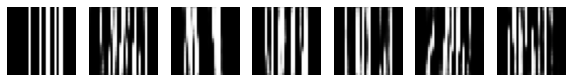

Epoch 881 gen_loss=3.062 disc_loss=0.240 real_acc=0.78 fake_acc=1.0
Epoch 882 gen_loss=3.425 disc_loss=0.215 real_acc=0.84 fake_acc=0.96
Epoch 883 gen_loss=3.133 disc_loss=0.248 real_acc=0.82 fake_acc=1.0
Epoch 884 gen_loss=2.464 disc_loss=0.261 real_acc=0.88 fake_acc=0.88
Epoch 885 gen_loss=1.938 disc_loss=0.211 real_acc=0.96 fake_acc=0.82
Epoch 886 gen_loss=2.317 disc_loss=0.182 real_acc=0.98 fake_acc=0.86
Epoch 887 gen_loss=2.329 disc_loss=0.164 real_acc=0.98 fake_acc=0.96
Epoch 888 gen_loss=2.956 disc_loss=0.160 real_acc=0.94 fake_acc=0.96
Epoch 889 gen_loss=3.563 disc_loss=0.227 real_acc=0.86 fake_acc=1.0
Epoch 890 gen_loss=3.197 disc_loss=0.223 real_acc=0.86 fake_acc=0.96


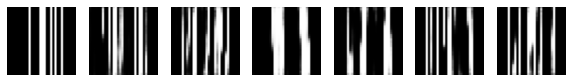

Epoch 891 gen_loss=3.072 disc_loss=0.171 real_acc=0.88 fake_acc=1.0
Epoch 892 gen_loss=2.102 disc_loss=0.250 real_acc=0.94 fake_acc=0.88
Epoch 893 gen_loss=1.838 disc_loss=0.240 real_acc=1.0 fake_acc=0.8
Epoch 894 gen_loss=2.539 disc_loss=0.176 real_acc=0.98 fake_acc=0.94
Epoch 895 gen_loss=2.942 disc_loss=0.114 real_acc=0.98 fake_acc=0.98
Epoch 896 gen_loss=3.142 disc_loss=0.153 real_acc=0.9 fake_acc=0.96
Epoch 897 gen_loss=3.079 disc_loss=0.198 real_acc=0.84 fake_acc=0.98
Epoch 898 gen_loss=2.978 disc_loss=0.252 real_acc=0.82 fake_acc=1.0
Epoch 899 gen_loss=2.821 disc_loss=0.247 real_acc=0.84 fake_acc=0.96
Epoch 900 gen_loss=1.918 disc_loss=0.233 real_acc=0.96 fake_acc=0.88


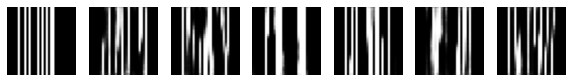

Epoch 901 gen_loss=2.278 disc_loss=0.237 real_acc=1.0 fake_acc=0.84
Epoch 902 gen_loss=2.230 disc_loss=0.245 real_acc=0.94 fake_acc=0.84
Epoch 903 gen_loss=2.651 disc_loss=0.187 real_acc=0.92 fake_acc=0.94
Epoch 904 gen_loss=3.204 disc_loss=0.309 real_acc=0.68 fake_acc=1.0
Epoch 905 gen_loss=3.134 disc_loss=0.268 real_acc=0.8 fake_acc=0.96
Epoch 906 gen_loss=2.577 disc_loss=0.246 real_acc=0.82 fake_acc=0.94
Epoch 907 gen_loss=2.124 disc_loss=0.192 real_acc=1.0 fake_acc=0.82
Epoch 908 gen_loss=1.904 disc_loss=0.215 real_acc=0.96 fake_acc=0.86


In [ ]:
epochs = 1000
for epoch in range(epochs):
    # take some random samples
    new_samples = sample_from_dataset(50,samples)
    # perform one training step (epoch)
    do_step(new_samples)
    if epoch % 10 == 0:
        show_results(epoch)
print("Done")

In [ ]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
plt.legend()
plt.show()

In [ ]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.show()

In [16]:
1e-3

0.001